Found 20 phase analysis files for 'kimi-k2'.
----------------------------------------
Displaying chart for: run_00000_phase_analysis.csv


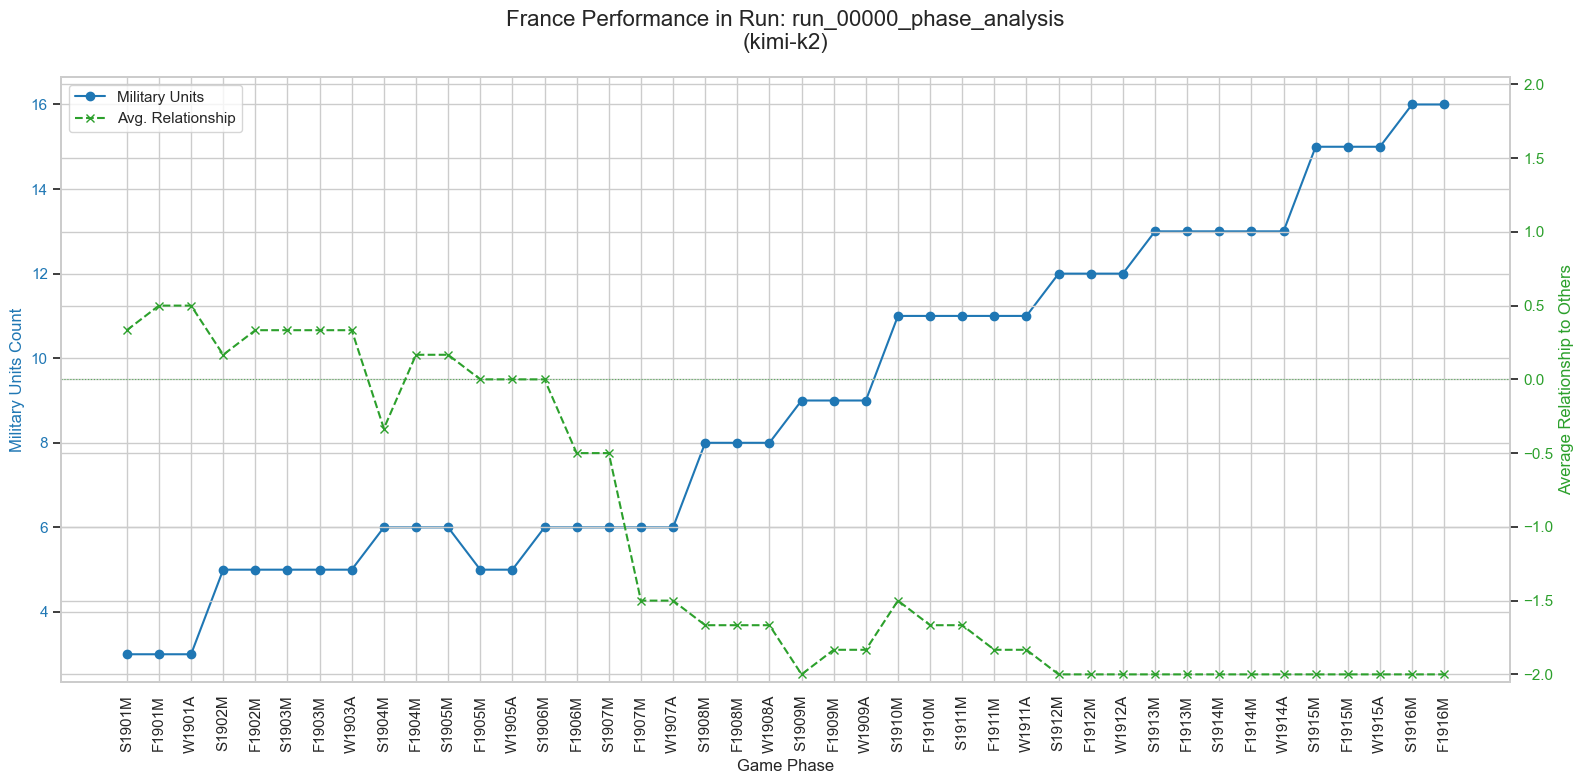

Displaying chart for: run_00001_phase_analysis.csv


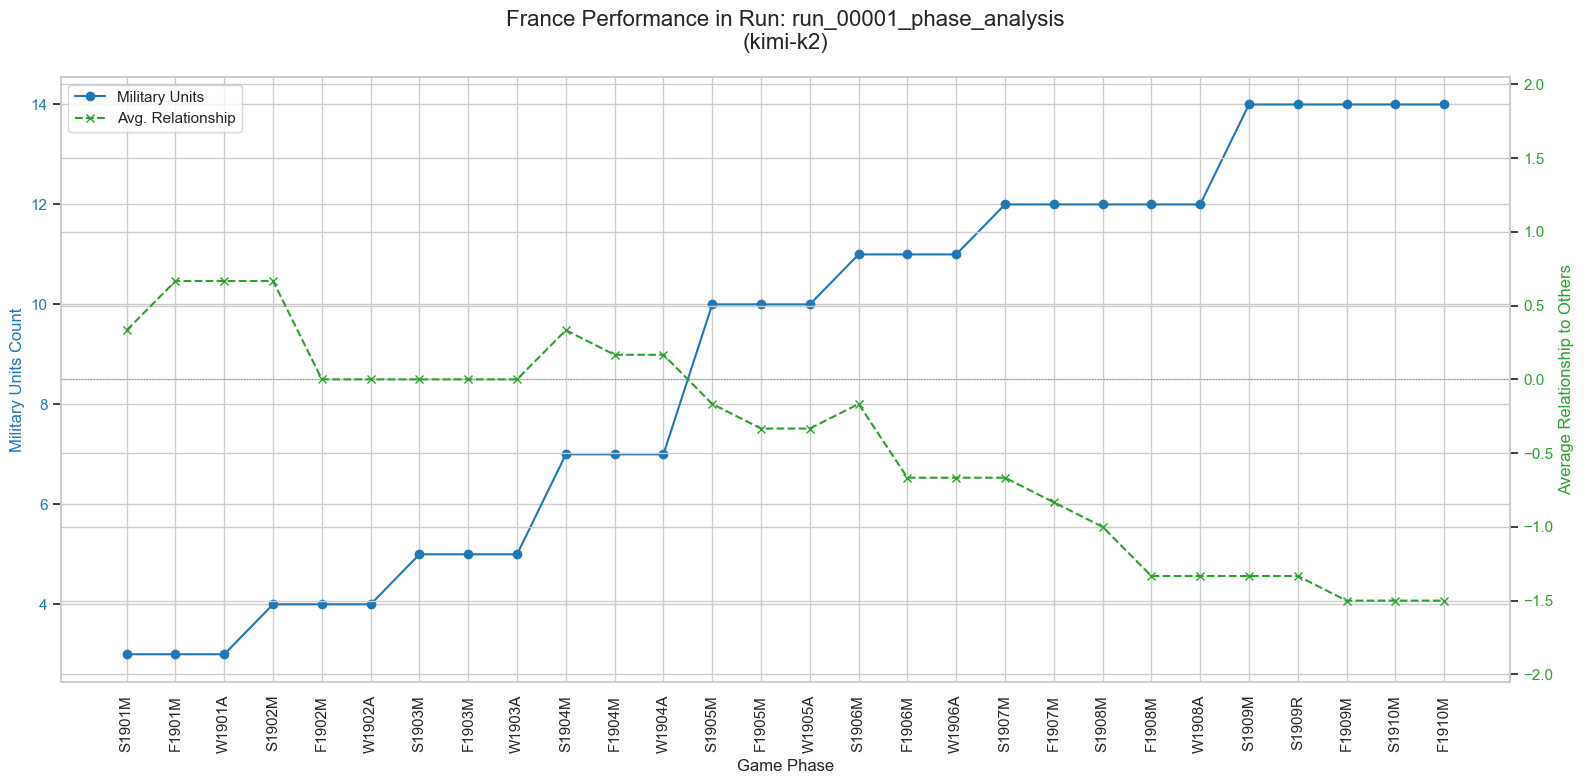

Displaying chart for: run_00002_phase_analysis.csv


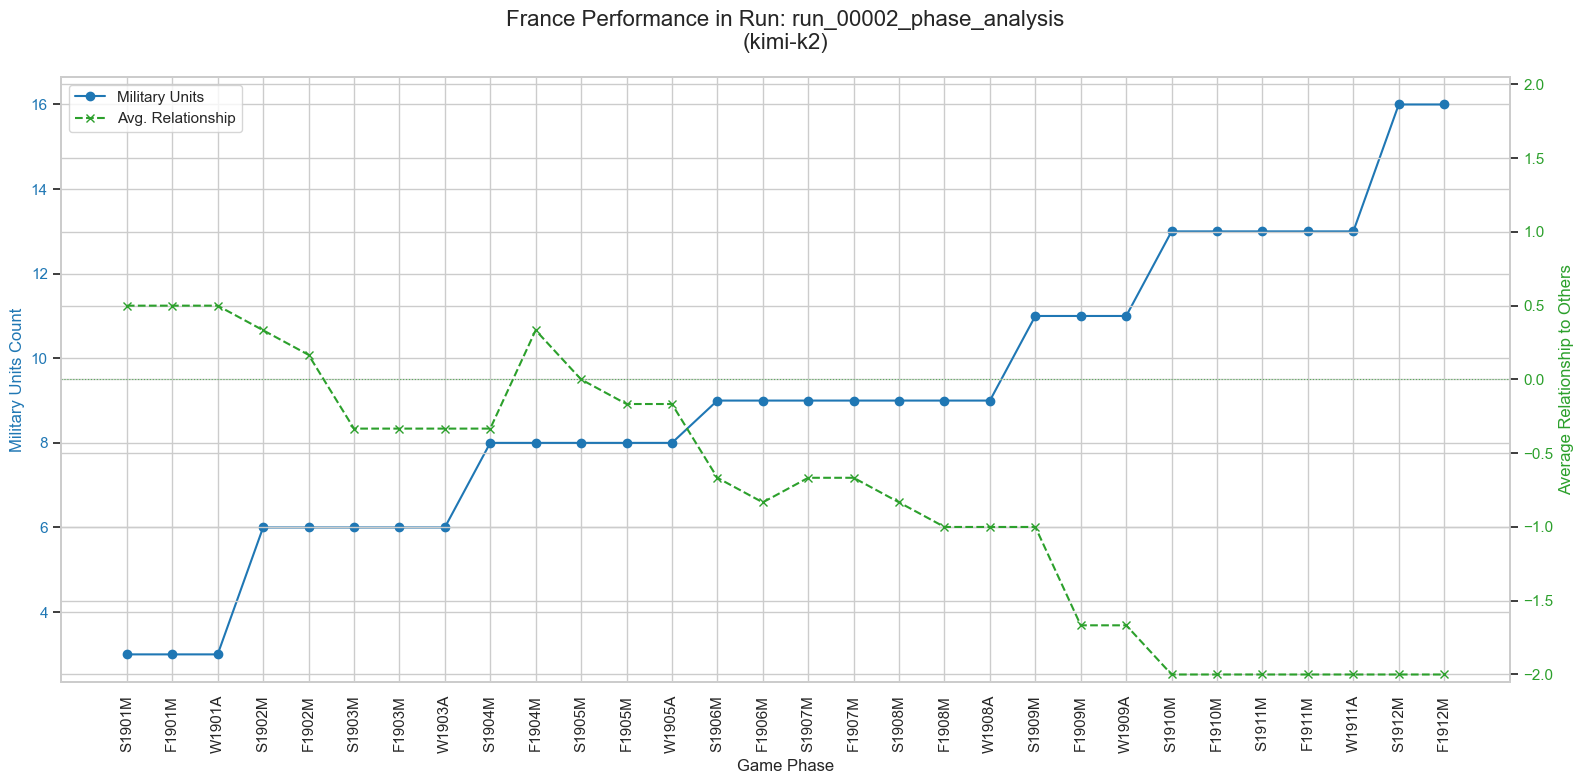

Displaying chart for: run_00003_phase_analysis.csv


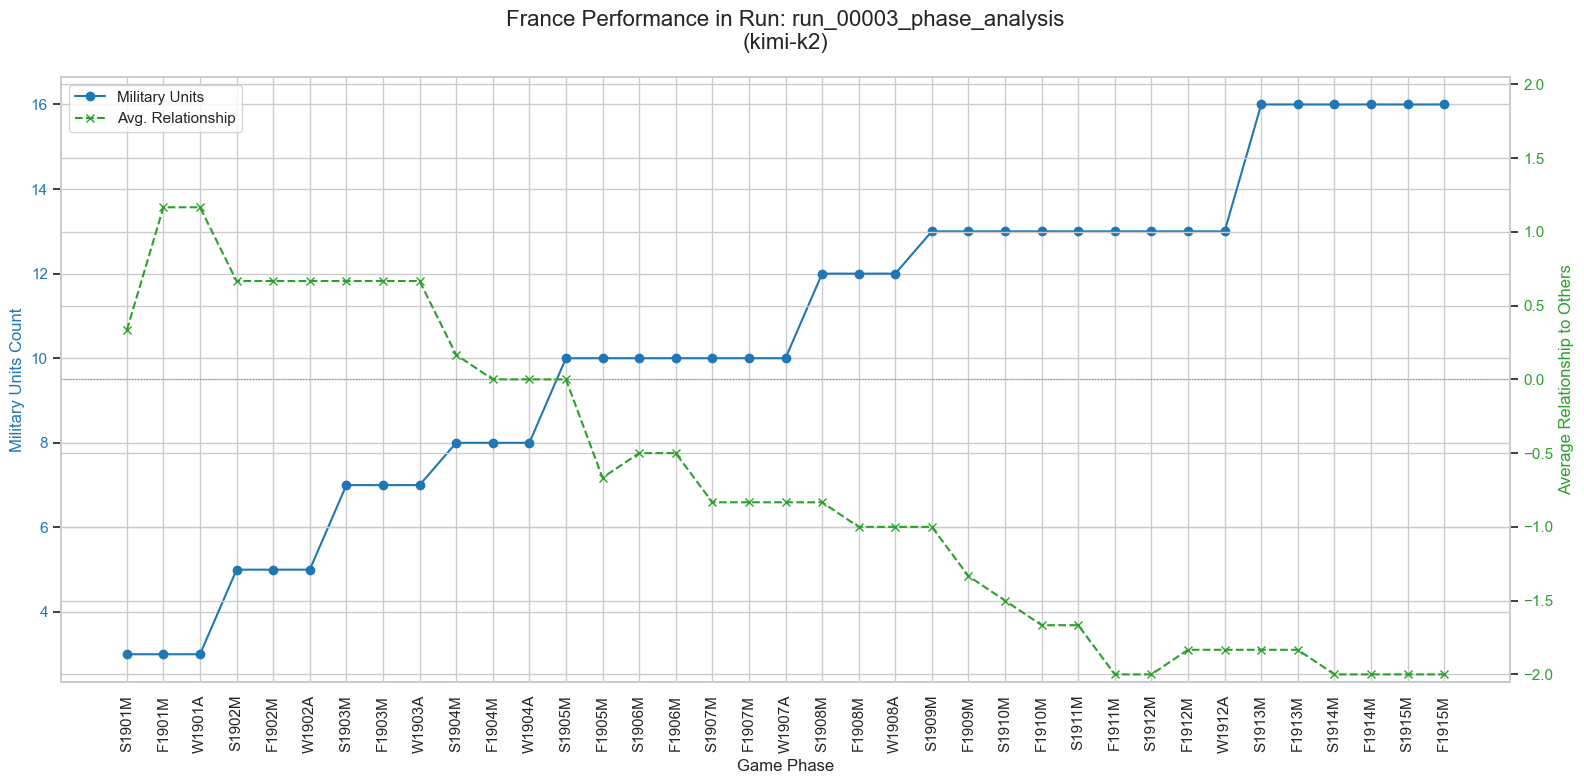

Displaying chart for: run_00004_phase_analysis.csv


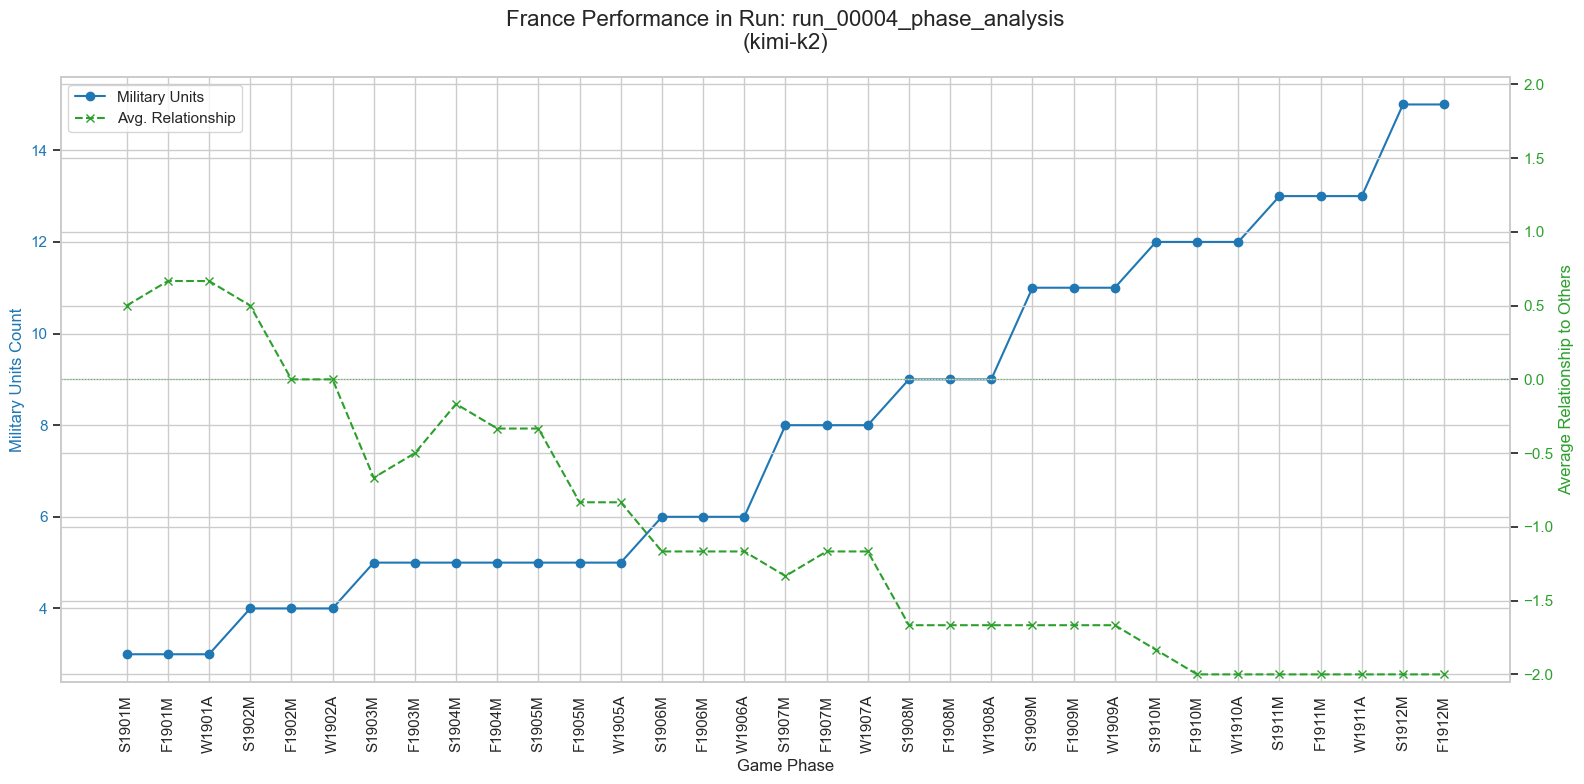

Displaying chart for: run_00005_phase_analysis.csv


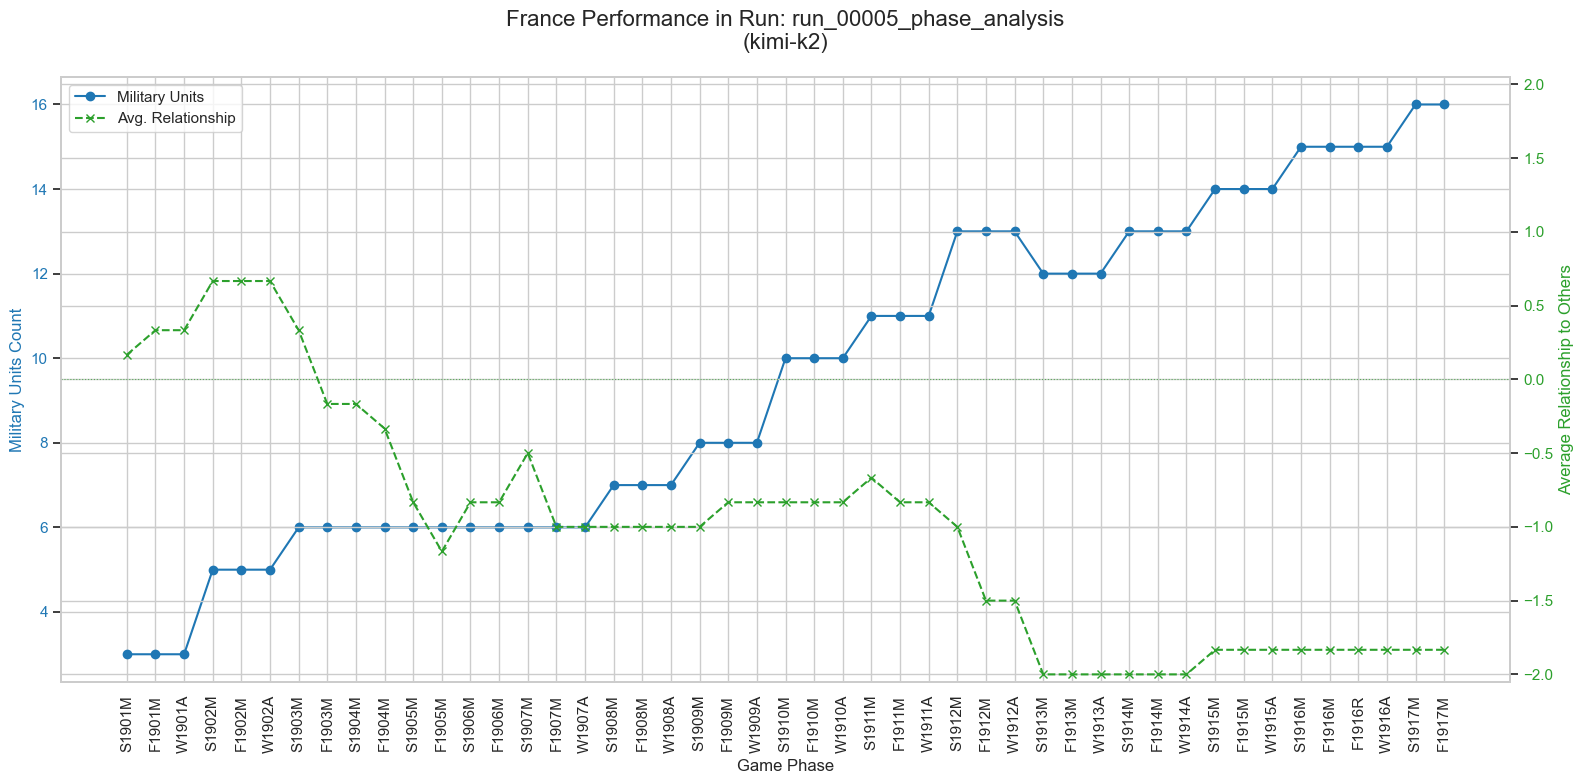

Displaying chart for: run_00006_phase_analysis.csv


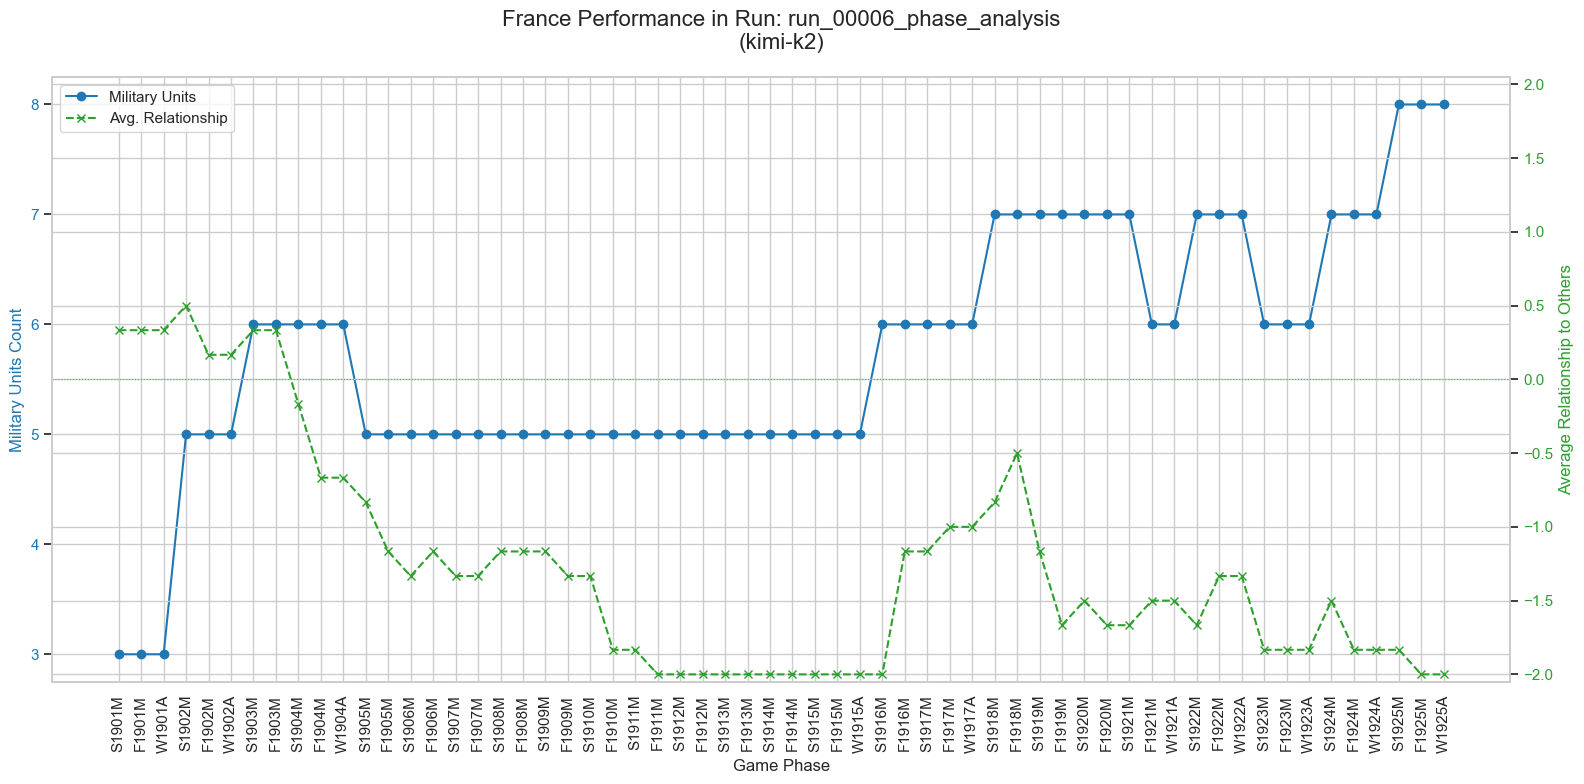

Displaying chart for: run_00007_phase_analysis.csv


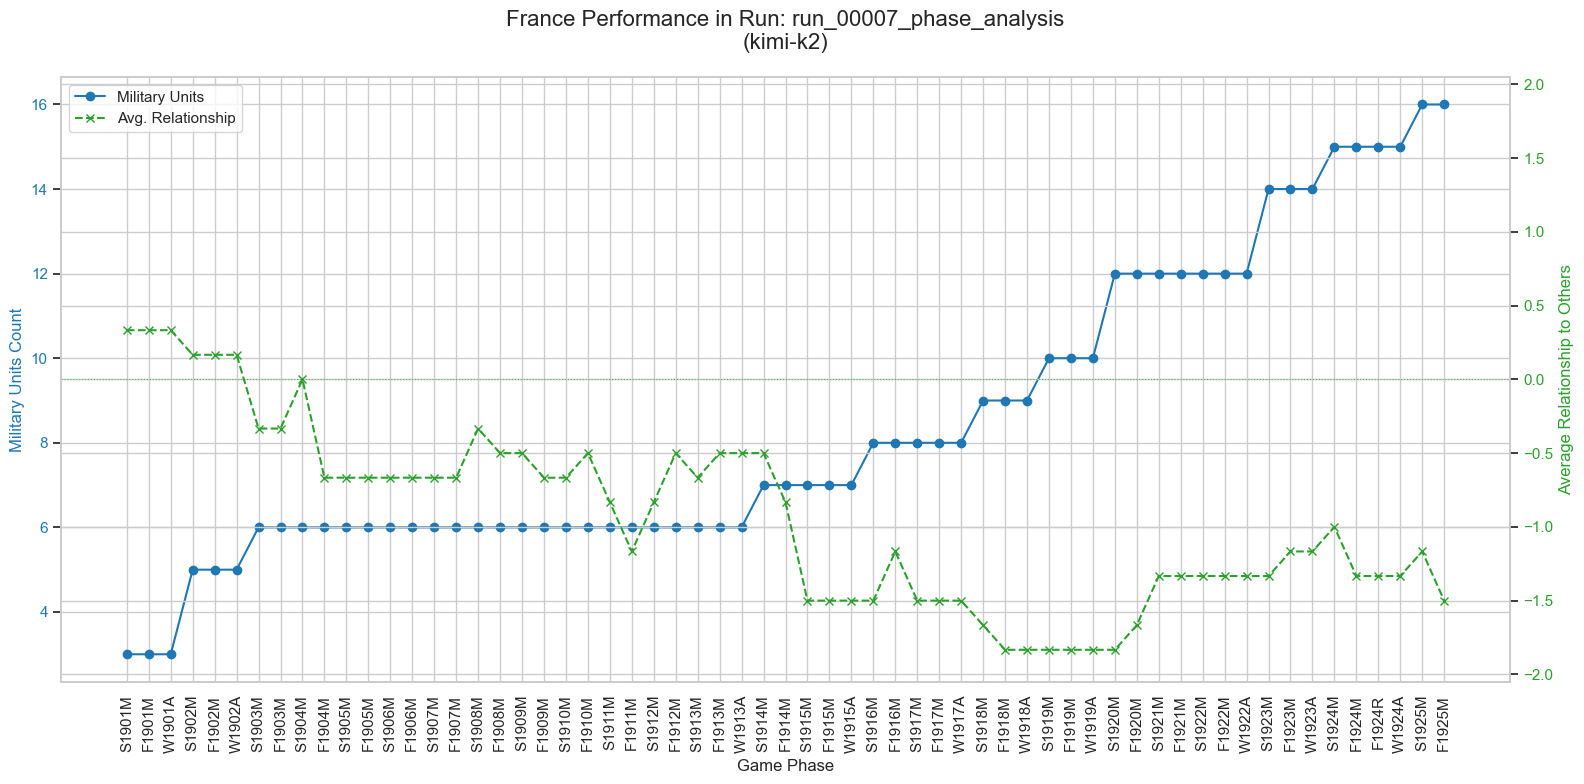

Displaying chart for: run_00008_phase_analysis.csv


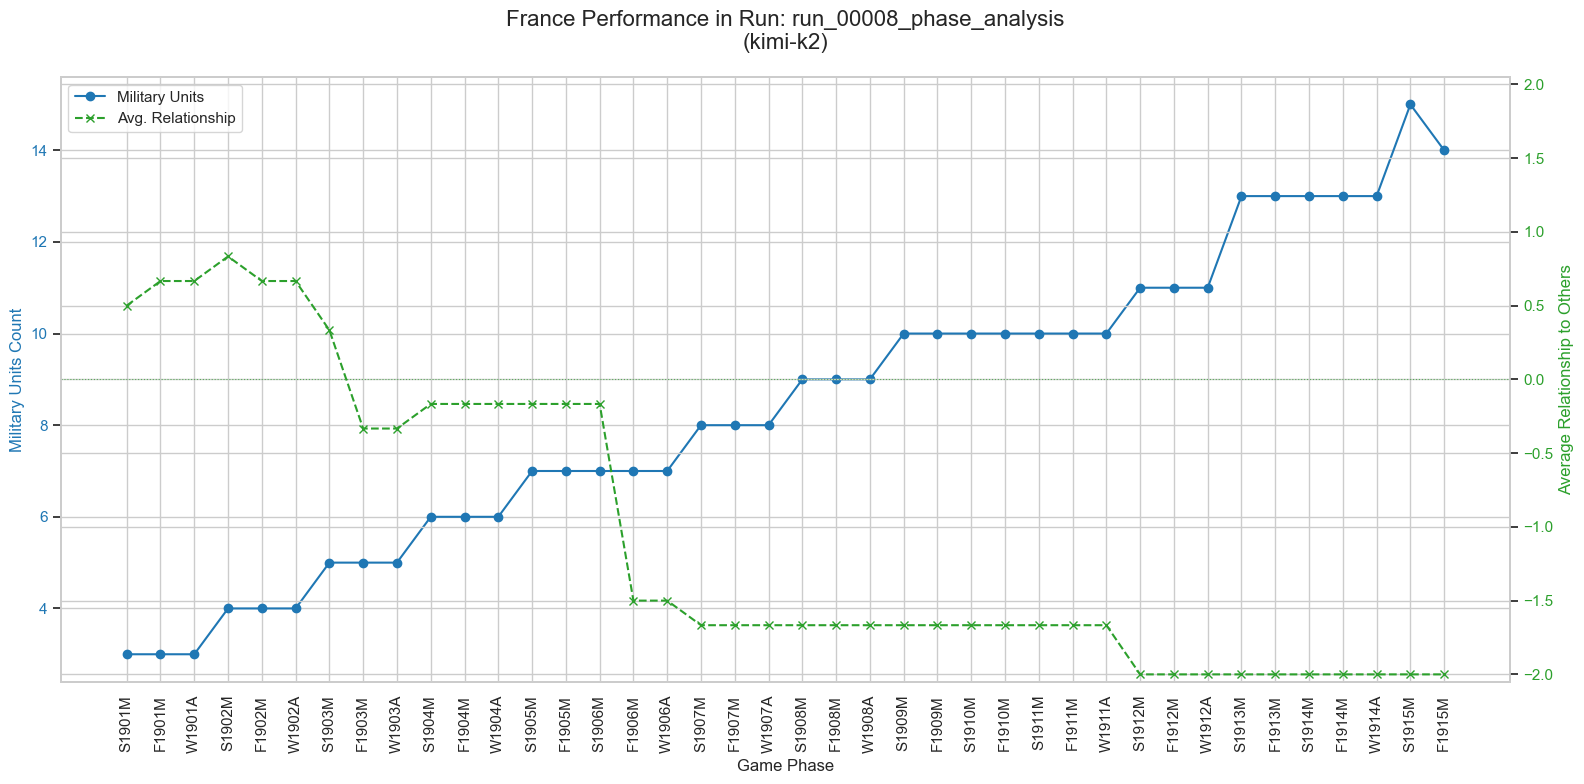

Displaying chart for: run_00009_phase_analysis.csv


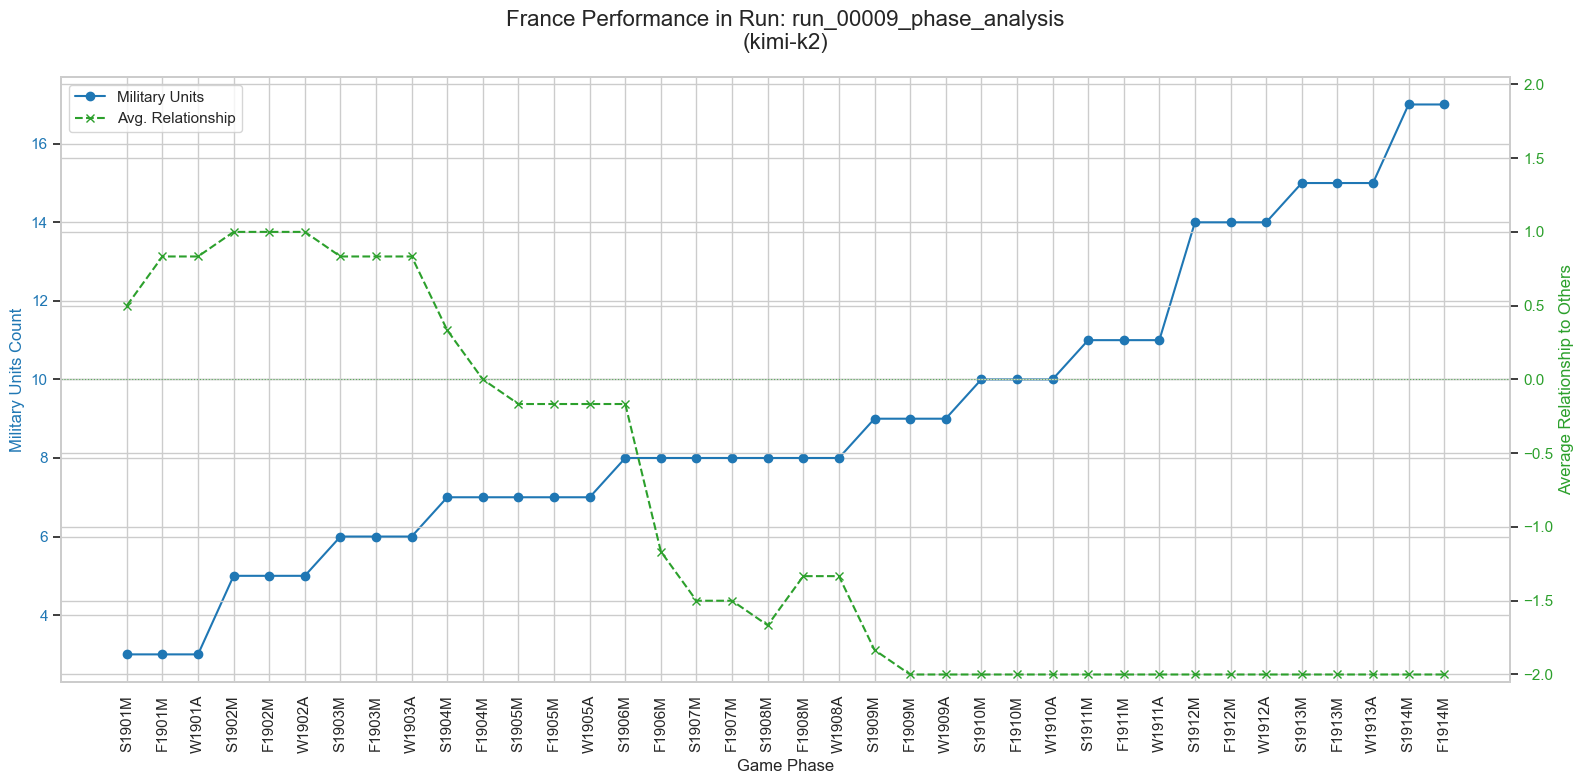

Displaying chart for: run_00010_phase_analysis.csv


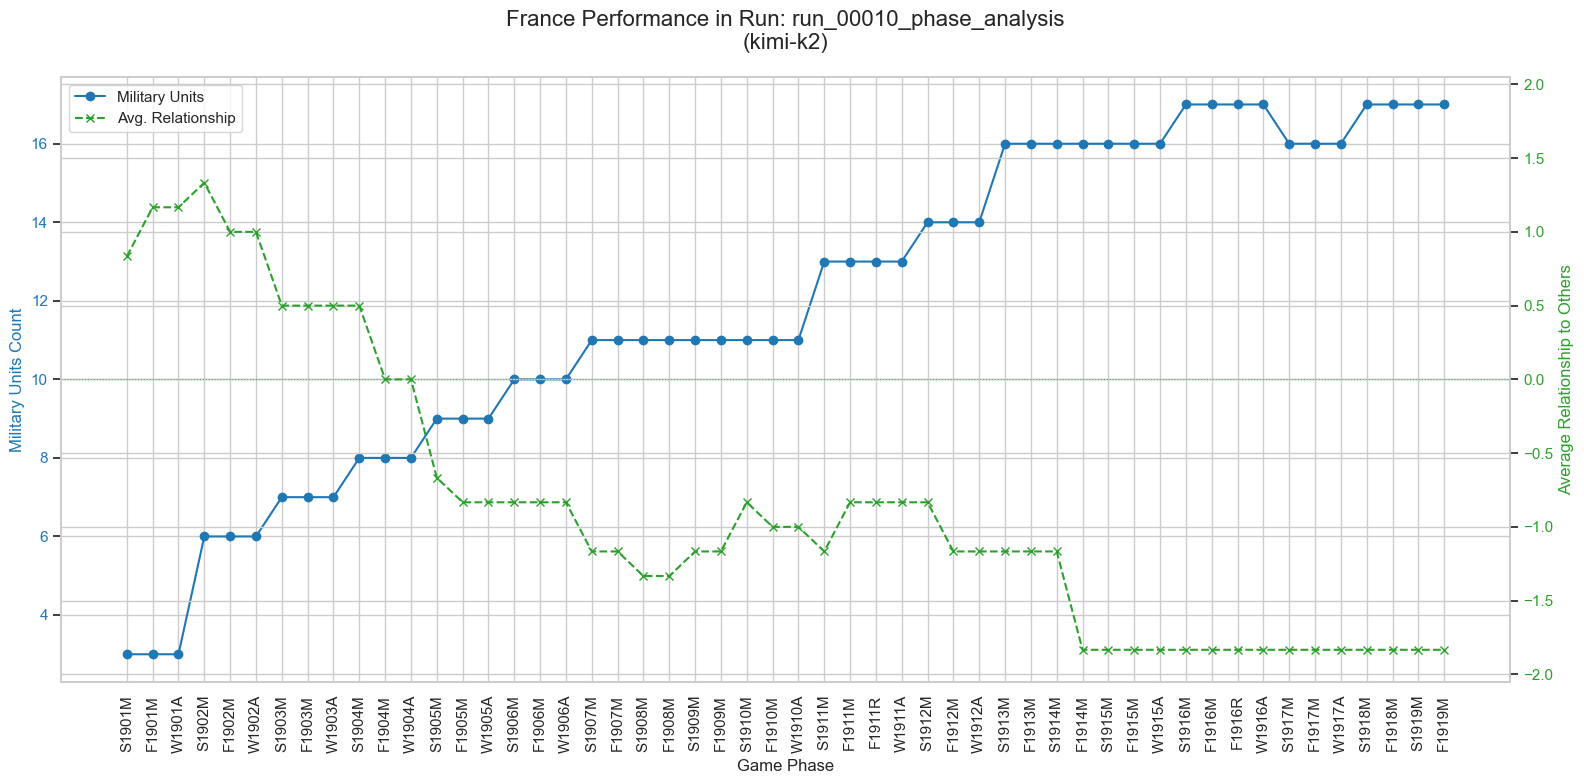

Displaying chart for: run_00011_phase_analysis.csv


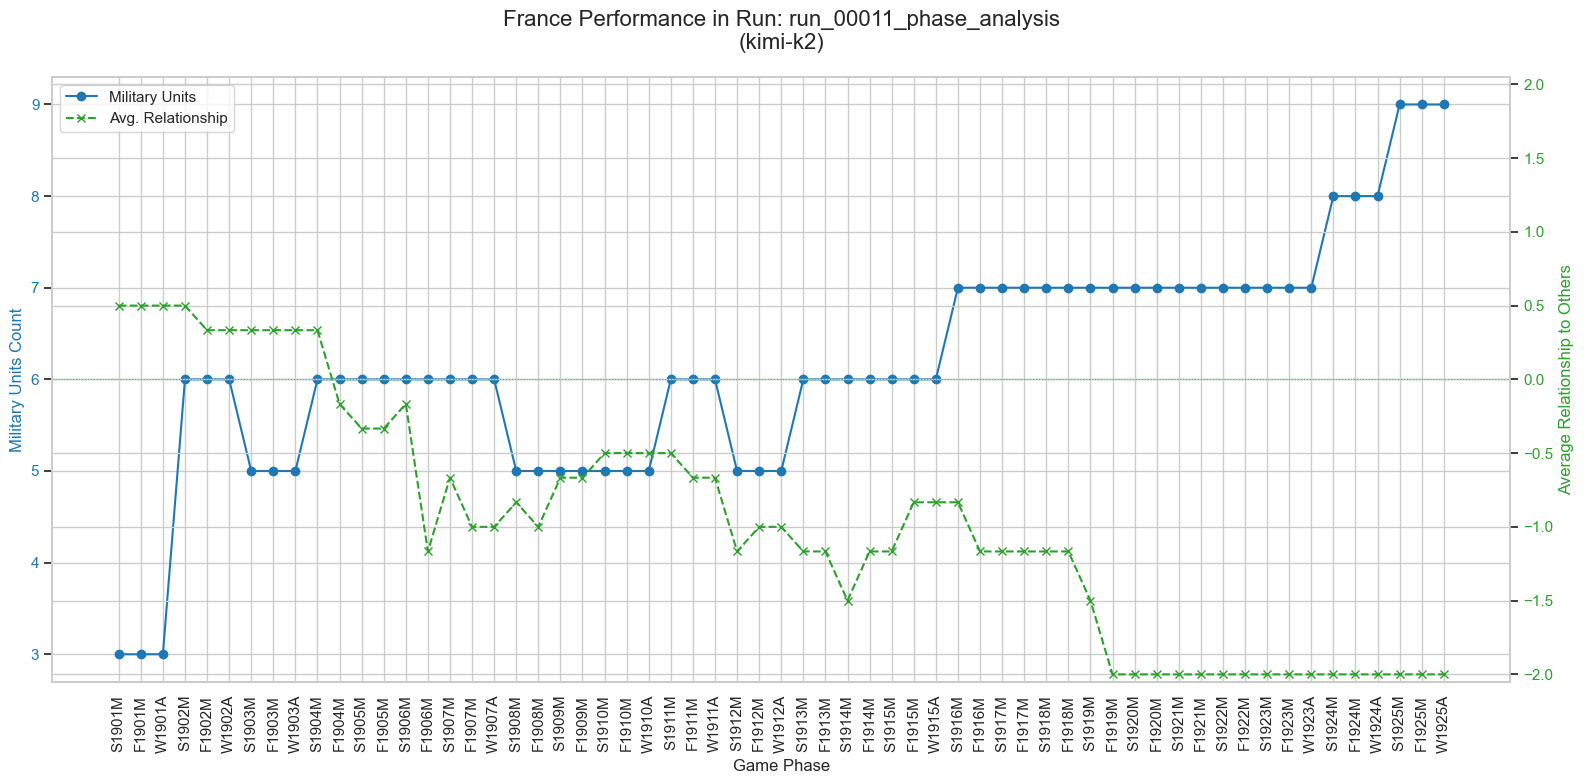

Displaying chart for: run_00012_phase_analysis.csv


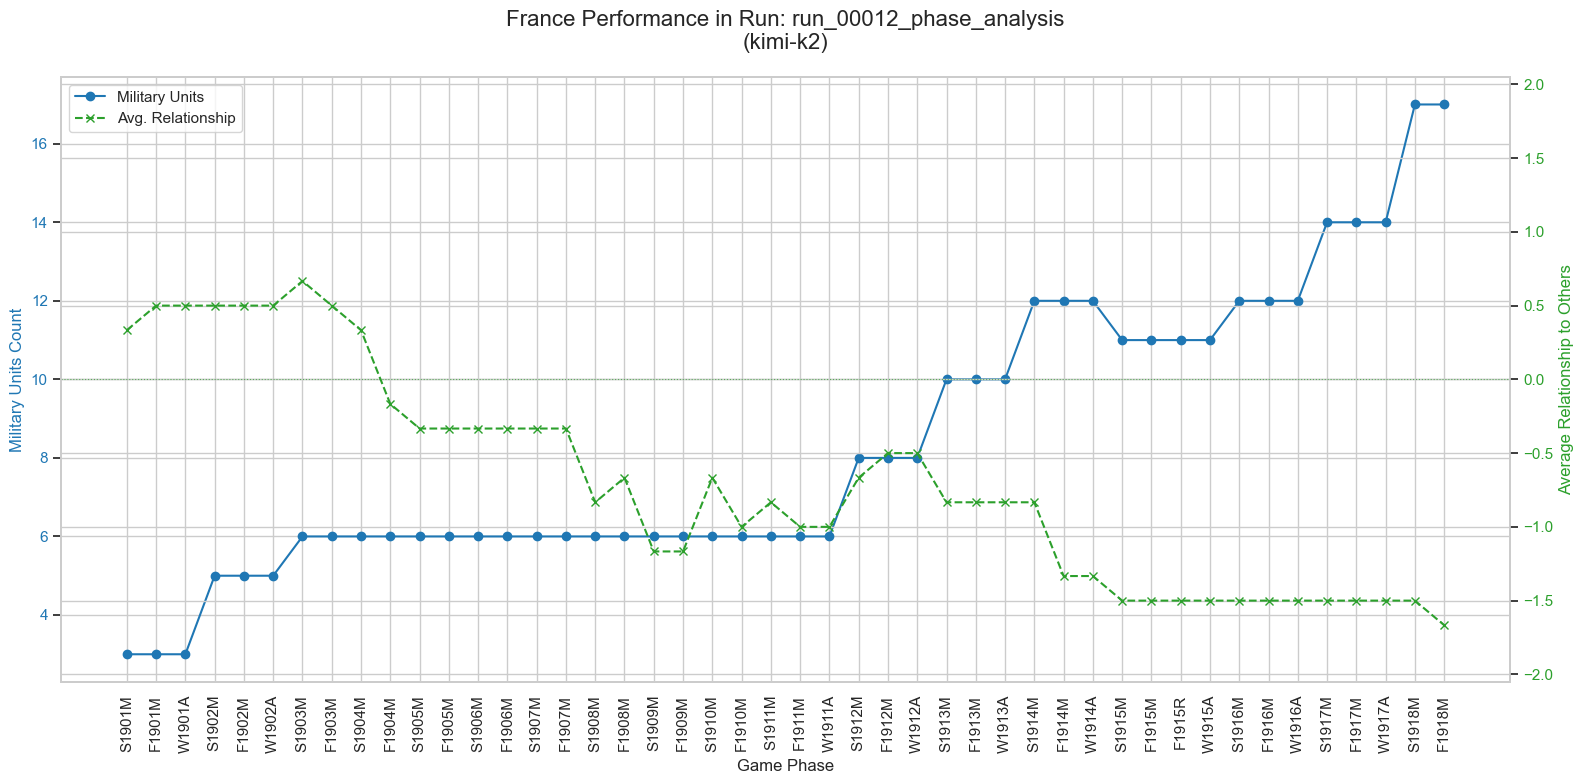

Displaying chart for: run_00013_phase_analysis.csv


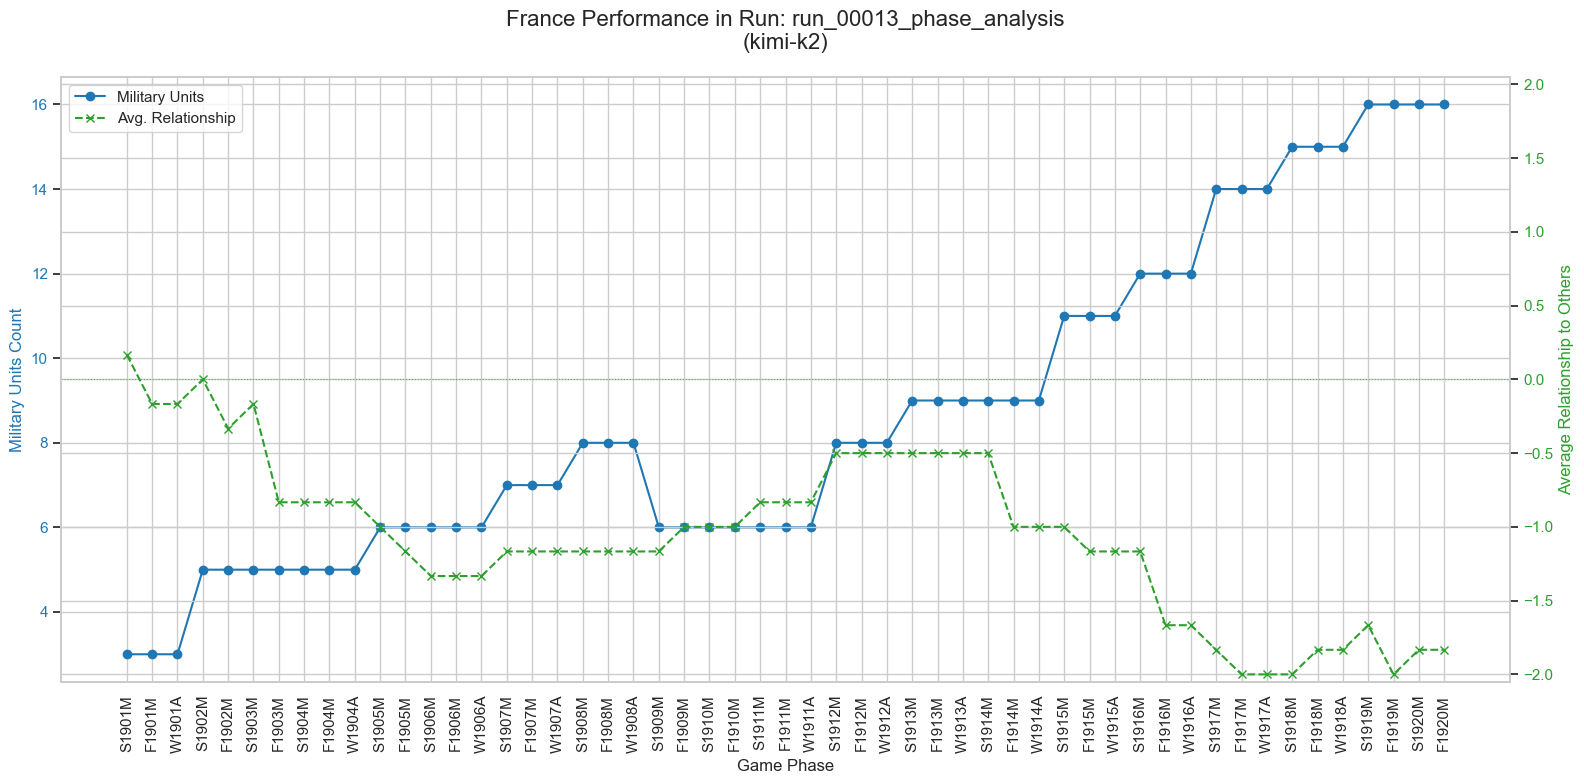

Displaying chart for: run_00014_phase_analysis.csv


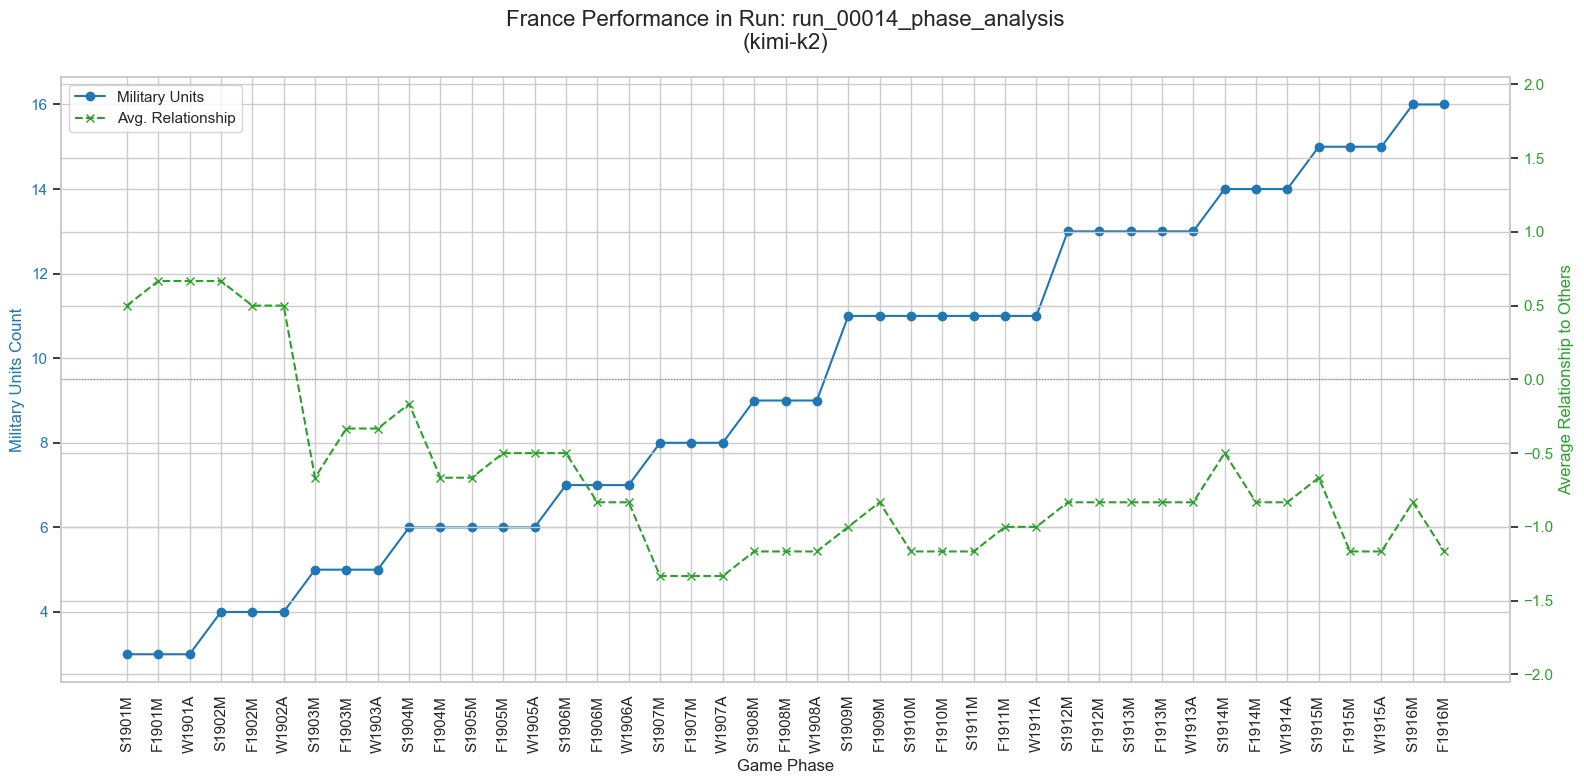

Displaying chart for: run_00015_phase_analysis.csv


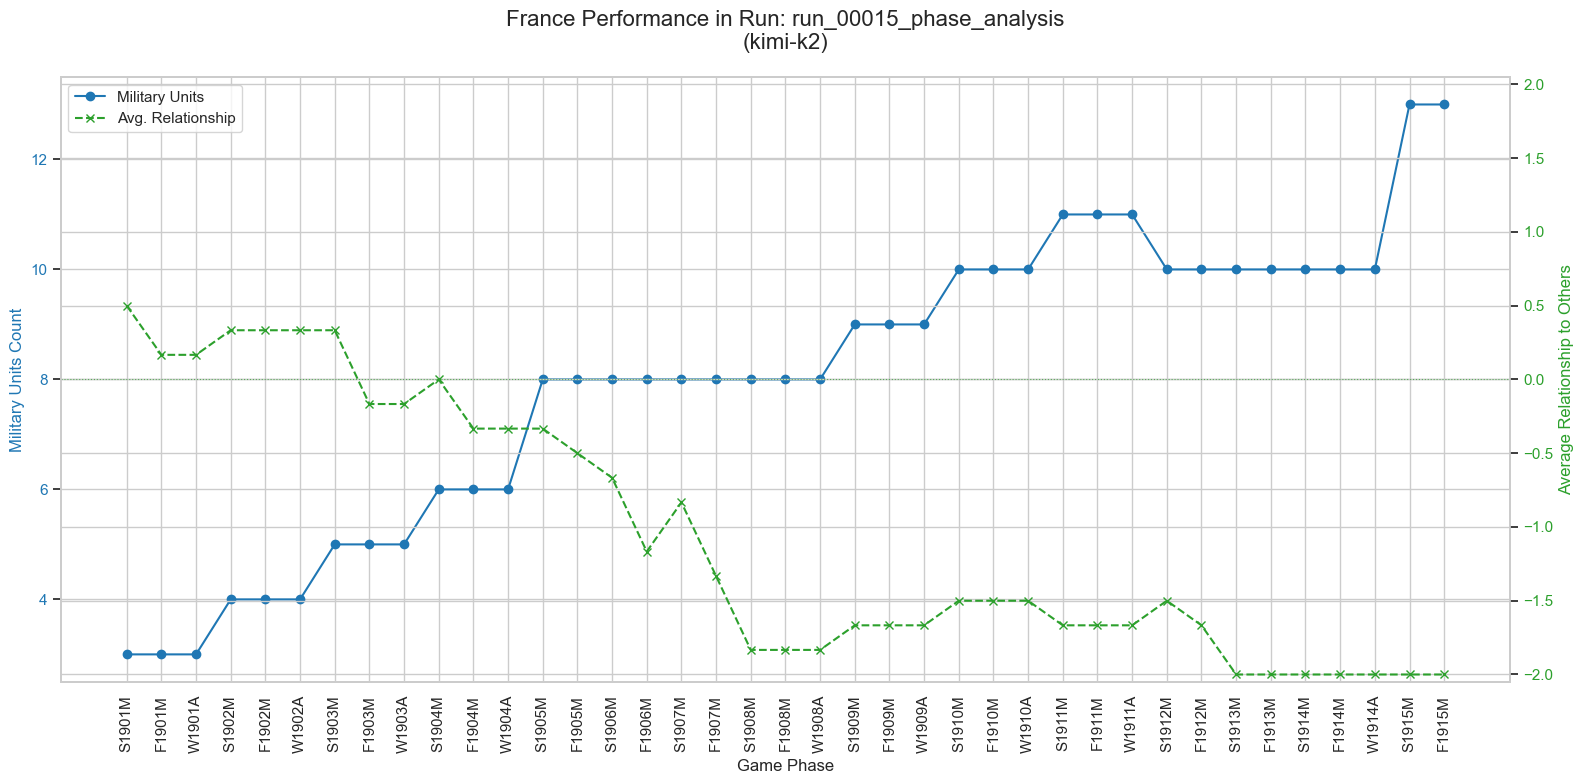

Displaying chart for: run_00016_phase_analysis.csv


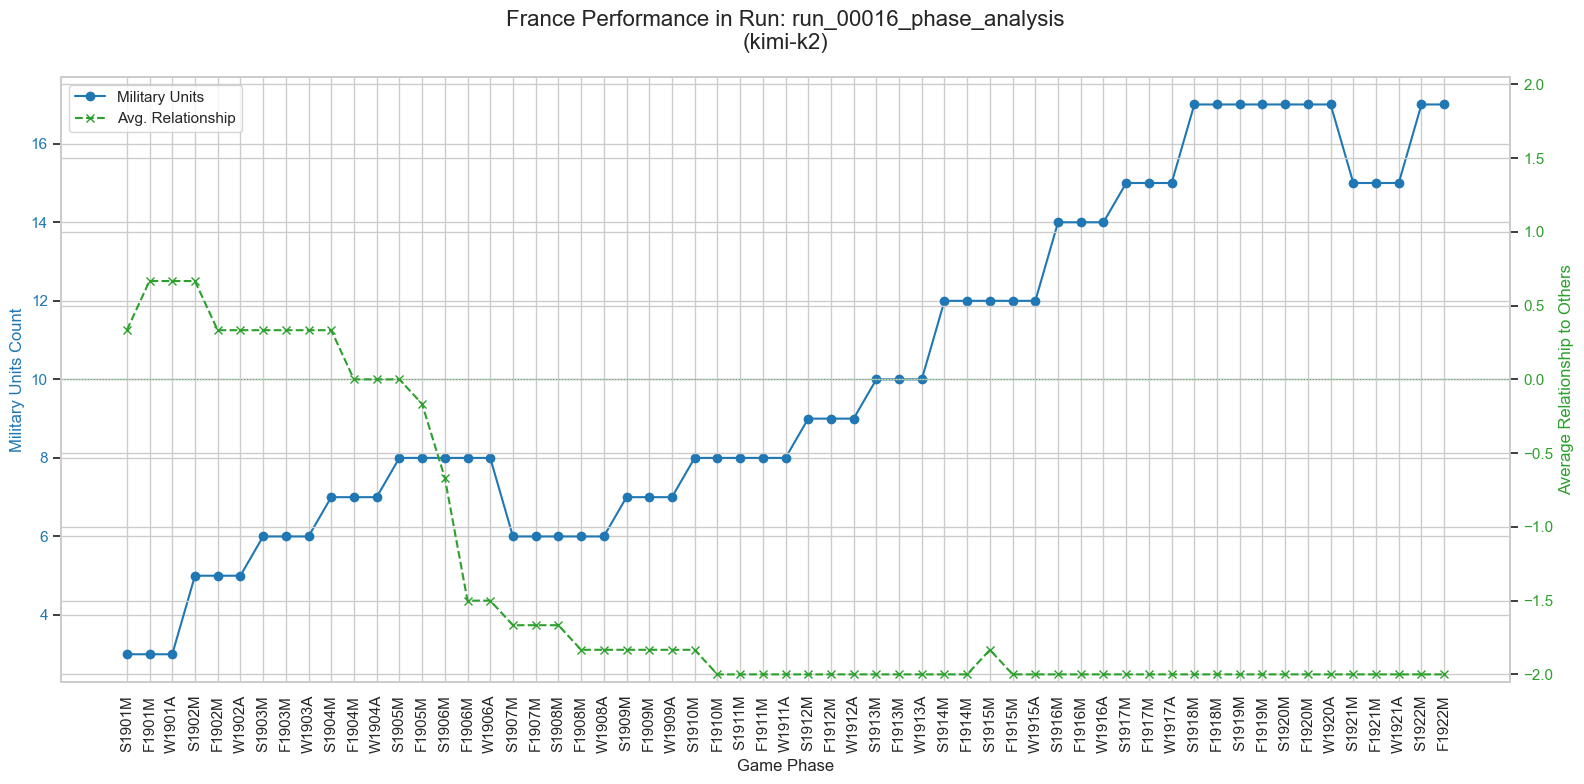

Displaying chart for: run_00017_phase_analysis.csv


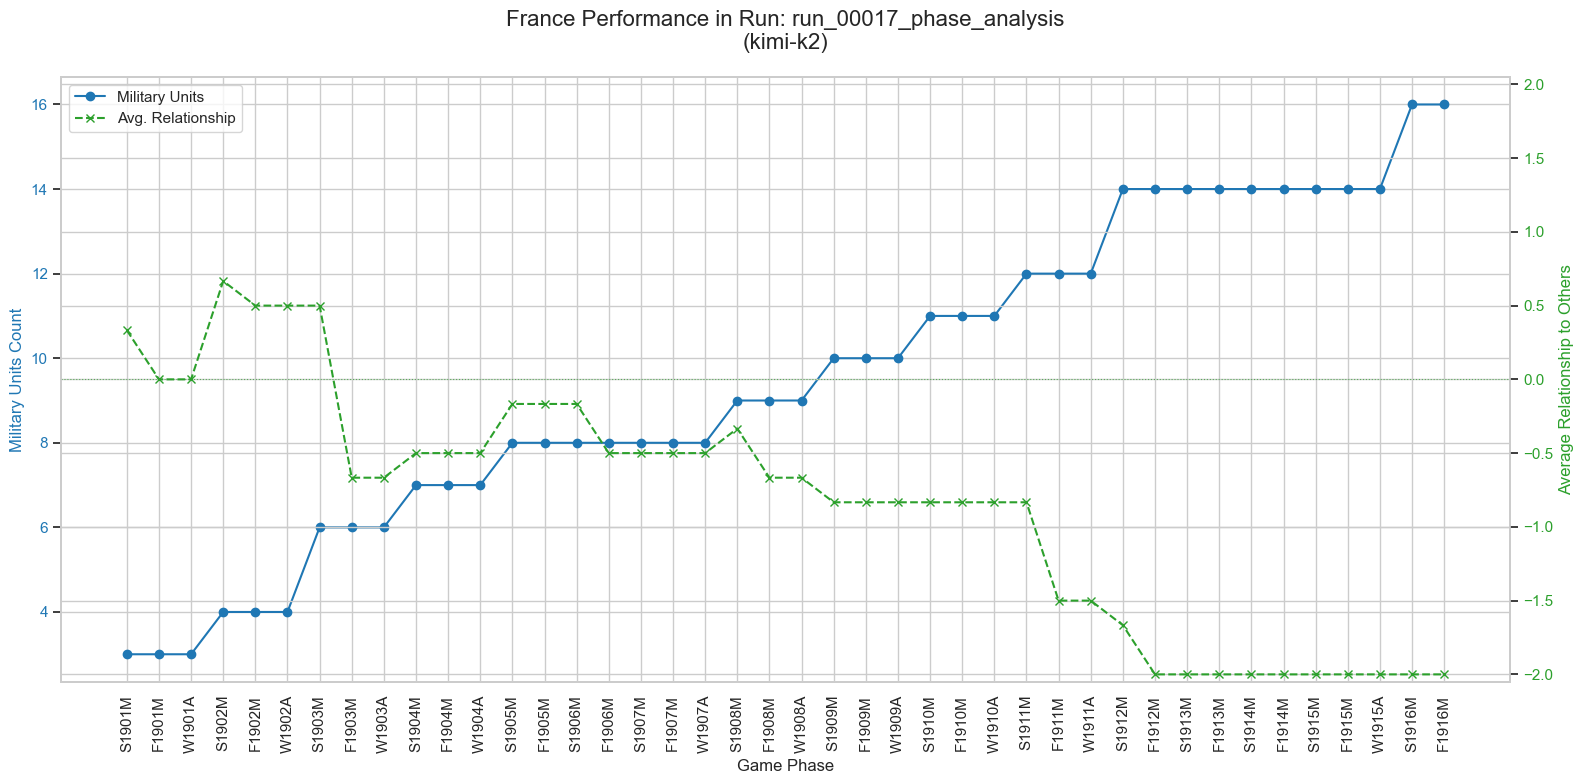

Displaying chart for: run_00018_phase_analysis.csv


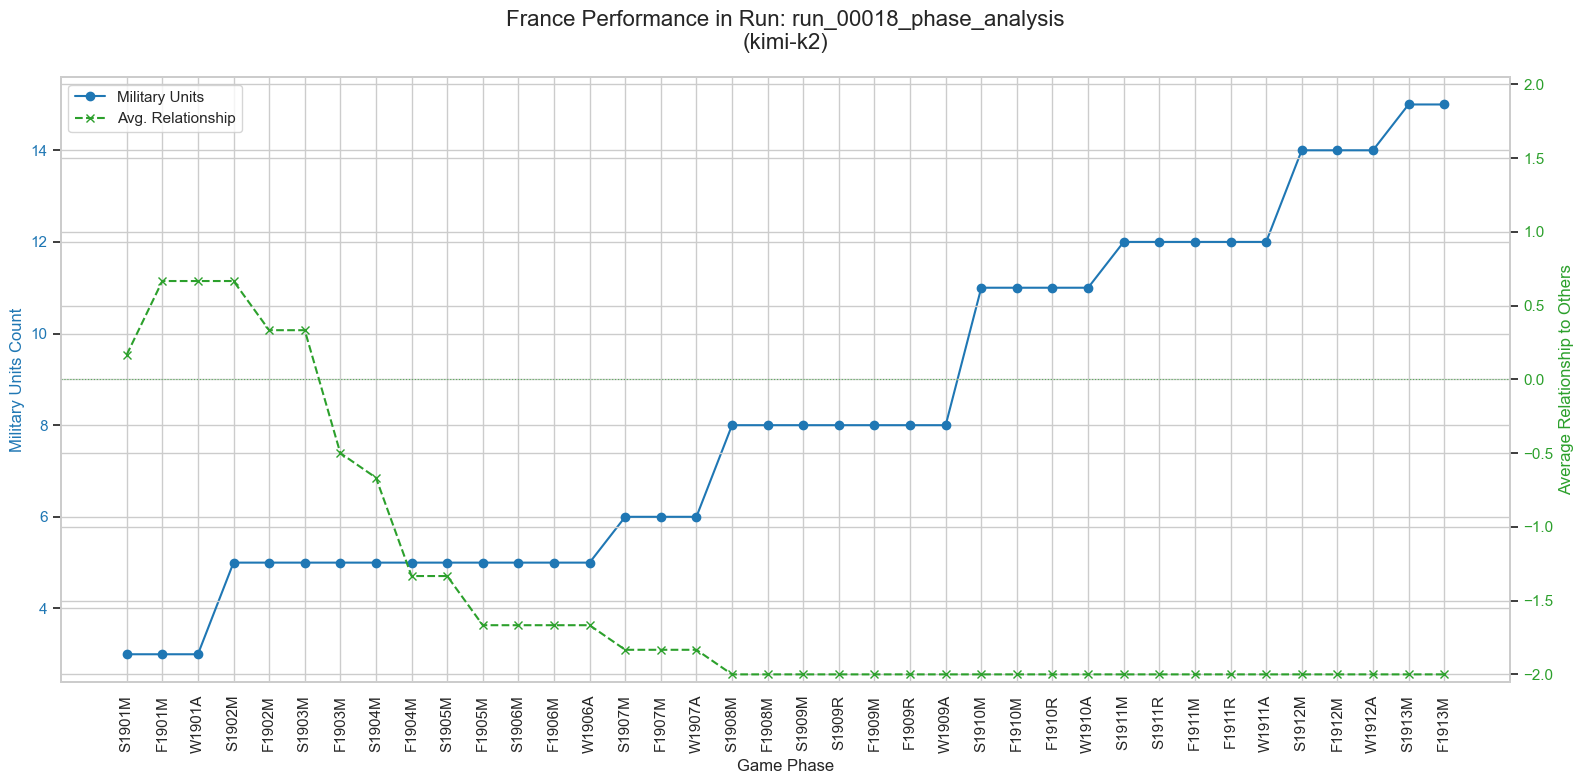

Displaying chart for: run_00019_phase_analysis.csv


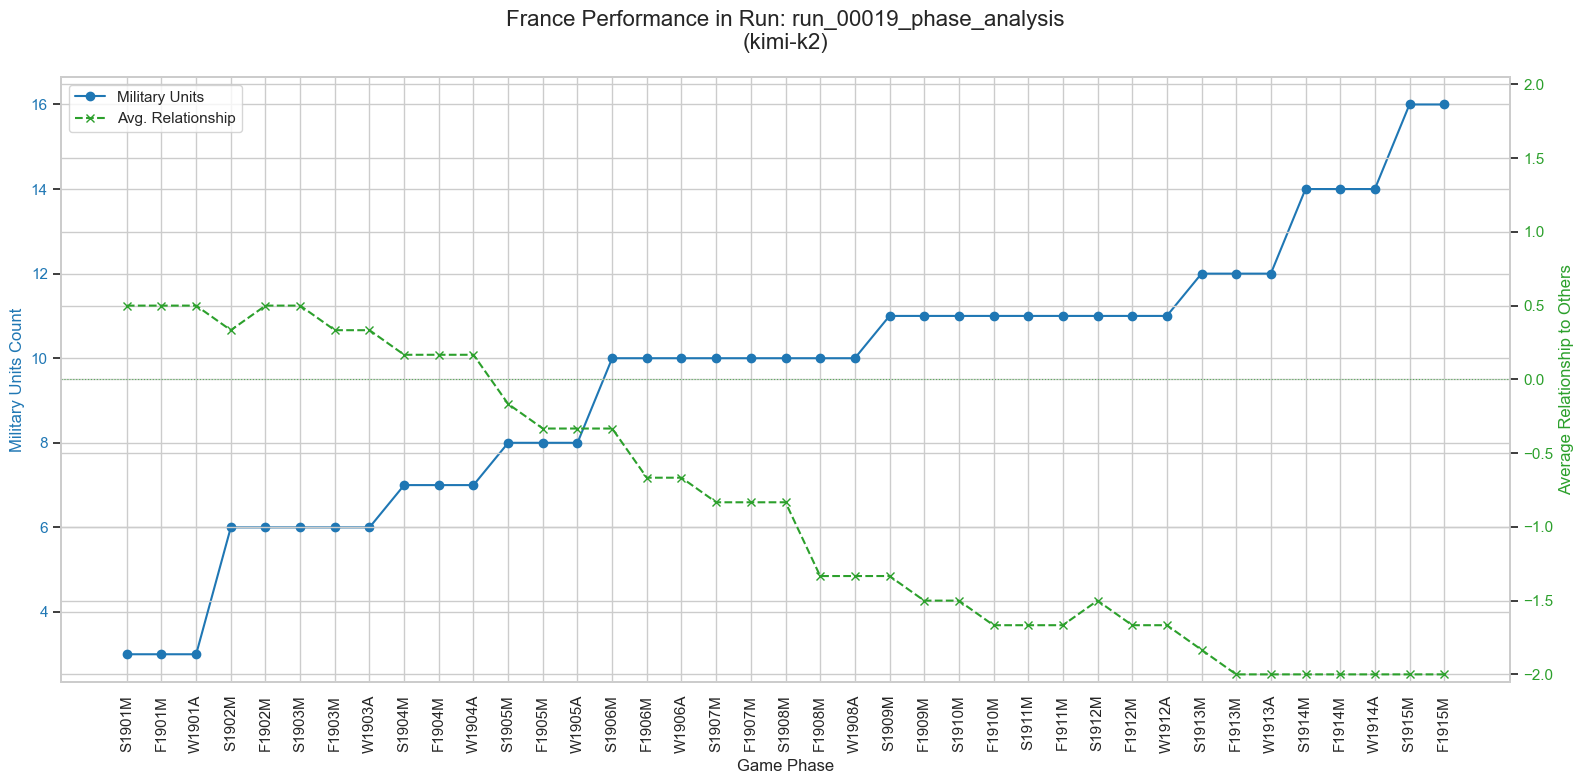


----------------------------------------
All individual runs processed. Now creating aggregate analysis.

--- Average Phase Data for France (All Runs) ---
   game_phase  avg_relationship_to_others  military_units_count
31     S1901M                    0.400000                   3.0
0      F1901M                    0.533333                   3.0
58     W1901A                    0.533333                   3.0
32     S1902M                    0.558333                   4.9
1      F1902M                    0.391667                   4.9
..        ...                         ...                   ...
29     F1924R                   -1.333333                  15.0
81     W1924A                   -1.722222                  10.0
57     S1925M                   -1.666667                  11.0
30     F1925M                   -1.833333                  11.0
82     W1925A                   -2.000000                   8.5

[83 rows x 3 columns]
--------------------------------------------------


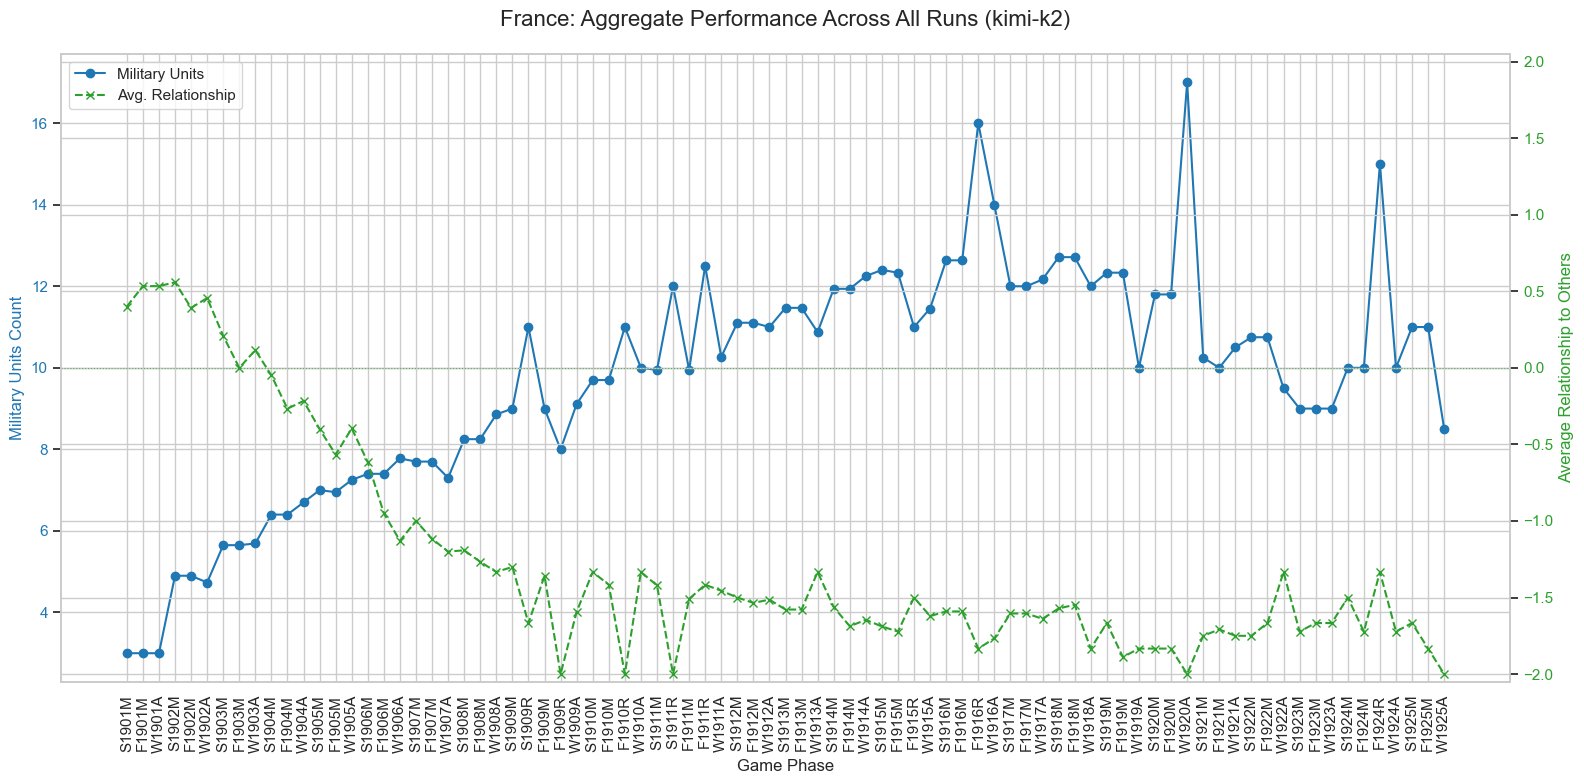

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# ---------------------------------------------------------------------------
# EDIT THE VALUES BELOW
# ---------------------------------------------------------------------------
EXP_DIR = "../data/sam-exp113-bench"
EXP_LABEL = "o3"

EXP_DIR = "../data/sam-exp080-bench"
EXP_LABEL = "kimi-k2"
# Set to True to see a chart for each game, False to only see the final aggregate chart
SHOW_INDIVIDUAL_PLOTS = True
# ---------------------------------------------------------------------------

def calculate_avg_relationship(relationship_str: str) -> float:
    """
    Parses the relationship string (e.g., "RUSSIA:0|GERMANY:1|ENGLAND:1|TURKEY")
    and calculates the average of the defined relationship values.
    
    - Ignores powers listed without a numeric value (like "TURKEY" in the example).
    - Returns NaN if the string is invalid or has no numeric relationships.
    """
    if not isinstance(relationship_str, str):
        return np.nan
    
    # Use regex to find all numeric values that follow a colon
    values = re.findall(r':(-?\d+\.?\d*)', relationship_str)
    
    if not values:
        return np.nan
        
    # Convert found string values to floats and calculate the mean
    numeric_values = [float(v) for v in values]
    return np.mean(numeric_values)

def sort_by_phase(df: pd.DataFrame) -> pd.DataFrame:
    """Sorts a dataframe chronologically by the 'game_phase' column."""
    df_copy = df.copy()
    df_copy['year'] = df_copy['game_phase'].str[1:5].astype(int)
    season_map = {'S': 0, 'F': 1, 'W': 2}
    df_copy['season_order'] = df_copy['game_phase'].str[0].map(season_map)
    sorted_df = df_copy.sort_values(by=['year', 'season_order']).drop(columns=['year', 'season_order'])
    return sorted_df

def plot_time_series(df: pd.DataFrame, title: str):
    """
    Generates a dual-axis time-series plot for military units and relationships.
    """
    sns.set_theme(style="whitegrid")
    fig, ax1 = plt.subplots(figsize=(16, 8))

    # Plot Military Units on the primary y-axis (ax1)
    color1 = 'tab:blue'
    ax1.set_xlabel("Game Phase", fontsize=12)
    ax1.set_ylabel("Military Units Count", color=color1, fontsize=12)
    ax1.plot(
        df["game_phase"],
        df["military_units_count"],
        color=color1,
        marker='o',
        linestyle='-',
        label="Military Units"
    )
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.tick_params(axis='x', rotation=90)

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot Average Relationship on the secondary y-axis (ax2)
    color2 = 'tab:green'
    ax2.set_ylabel("Average Relationship to Others", color=color2, fontsize=12)
    ax2.plot(
        df["game_phase"],
        df["avg_relationship_to_others"],
        color=color2,
        marker='x',
        linestyle='--',
        label="Avg. Relationship"
    )
    ax2.tick_params(axis='y', labelcolor=color2)
    # Set y-lim for relationship to be consistent, e.g., from -1 to 1
    ax2.set_ylim(-2.05, 2.05)
    ax2.axhline(0, color=color2, linestyle=':', linewidth=0.8, alpha=0.7)

    # Final plot adjustments
    plt.title(title, fontsize=16, pad=20)
    fig.tight_layout()
    
    # Create a unified legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.show()


# ---------------------------------------------------------------------------
# Main script logic
# ---------------------------------------------------------------------------
all_phase_data_for_aggregation = []
exp_path = Path(EXP_DIR).expanduser().resolve()
csv_dir = exp_path / "analysis" / "statistical_game_analysis" / "individual"

if not csv_dir.exists():
    raise FileNotFoundError(f"Directory not found, please check the path: {csv_dir}")

csv_files = sorted(csv_dir.glob("run_*_phase_analysis.csv"))

if not csv_files:
    raise FileNotFoundError(f"No phase analysis CSVs found in {csv_dir}")

print(f"Found {len(csv_files)} phase analysis files for '{EXP_LABEL}'.")
print("-" * 40)

# --- Loop 1: Process each run individually and plot ---
for csv_file in csv_files:
    try:
        run_df = pd.read_csv(csv_file)
        
        # Filter for France and the specific response type
        france_df = run_df[
            (run_df["power_name"] == "FRANCE") &
            (run_df["analyzed_response_type"] == "order_generation")
        ].copy()
        
        if france_df.empty:
            print(f"info: no France 'order_generation' data in {csv_file.name}")
            continue

        # --- Calculate our new metric ---
        france_df['avg_relationship_to_others'] = france_df['relationships'].apply(calculate_avg_relationship)
        
        # Sort data chronologically
        france_df_sorted = sort_by_phase(france_df)
        
        # Keep only the columns we need
        relevant_cols = [
            "game_phase",
            "avg_relationship_to_others",
            "military_units_count"
        ]
        france_df_final = france_df_sorted[relevant_cols].dropna()

        # Store the processed data for the final aggregation step
        all_phase_data_for_aggregation.append(france_df_final)

        # Plot the individual run if requested
        if SHOW_INDIVIDUAL_PLOTS:
            print(f"Displaying chart for: {csv_file.name}")
            plot_title = f"France Performance in Run: {csv_file.stem}\n({EXP_LABEL})"
            plot_time_series(france_df_final, plot_title)

    except Exception as exc:
        print(f"warning: could not process {csv_file} – {exc}")

# --- Process and plot the aggregated data ---
if not all_phase_data_for_aggregation:
    raise RuntimeError("No data collected. Check CSV contents and filters.")

print("\n" + "-" * 40)
print("All individual runs processed. Now creating aggregate analysis.")

# Concatenate all dataframes from all runs
combined_df = pd.concat(all_phase_data_for_aggregation, ignore_index=True)

# Group by game phase and calculate the mean across all runs
avg_phase_df = combined_df.groupby("game_phase").mean().reset_index()

# Sort the final aggregated dataframe
avg_phase_df_sorted = sort_by_phase(avg_phase_df)

print("\n--- Average Phase Data for France (All Runs) ---")
print(avg_phase_df_sorted)
print("-" * 50)

# Plot the final aggregated data
aggregate_title = f"France: Aggregate Performance Across All Runs ({EXP_LABEL})"
plot_time_series(avg_phase_df_sorted, aggregate_title)

Processing data for specified models...

Analysis 1: Global Average 'Relationship per Unit'
Higher value = more 'friendliness' per unit on the board.
model
kimi-k2    0.056454
o3         0.082966
Name: relationship_per_unit, dtype: float64
------------------------------------------------------------

Analysis 2: Per-Match 'Relationship per Unit' Distribution
Comparing the typical 'friendliness efficiency' across all games for each model.
--- Distribution Summary Statistics ---
         count      mean       std       min       25%       50%       75%  \
model                                                                        
kimi-k2   20.0  0.056962  0.014575  0.024195  0.049689  0.056141  0.062098   
o3        20.0  0.082849  0.013185  0.066795  0.075399  0.081939  0.085527   

              max  
model              
kimi-k2  0.083471  
o3       0.128853  
------------------------------------------------------------


/tmp/ipykernel_12511/3692065041.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_12511/3692065041.py:155: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


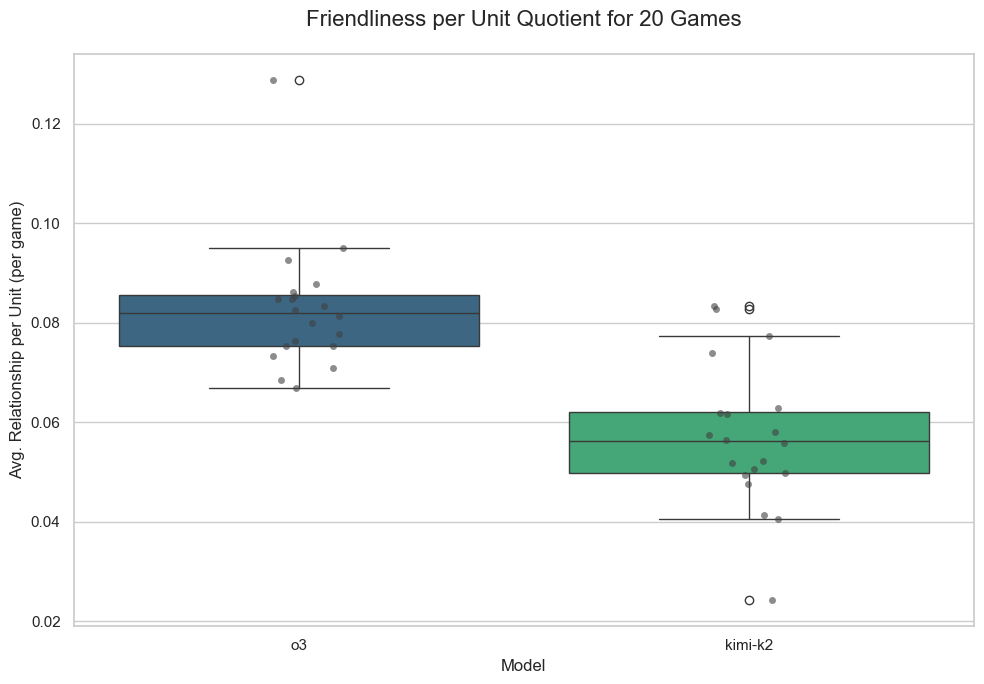

In [15]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# ---------------------------------------------------------------------------
# Configuration: Paths to the two experiment folders to compare
# ---------------------------------------------------------------------------
exp_dirs = {
    "o3": "../data/sam-exp113-bench",
    "kimi-k2": "../data/sam-exp080-bench",
}

# ---------------------------------------------------------------------------
# Helper Functions (re-used from previous analysis)
# ---------------------------------------------------------------------------
def calculate_avg_relationship(relationship_str: str) -> float:
    """
    Parses the relationship string and calculates the average of the defined values.
    """
    if not isinstance(relationship_str, str):
        return np.nan
    values = re.findall(r':(-?\d+\.?\d*)', relationship_str)
    if not values:
        return np.nan
    return np.mean([float(v) for v in values])

def normalize_value(value, old_min, old_max, new_min, new_max):
    """Scales a value from an old range to a new range."""
    return new_min + (value - old_min) * (new_max - new_min) / (old_max - old_min)

# ---------------------------------------------------------------------------
# 1. Load and Process Data for Both Models
# ---------------------------------------------------------------------------
all_processed_data = []

print("Processing data for specified models...")
for model_label, exp_dir in exp_dirs.items():
    exp_path = Path(exp_dir).expanduser().resolve()
    csv_dir = exp_path / "analysis" / "statistical_game_analysis" / "individual"
    
    if not csv_dir.exists():
        print(f"warning: directory not found, skipping model '{model_label}': {csv_dir}")
        continue
        
    csv_files = sorted(csv_dir.glob("run_*_phase_analysis.csv"))
    
    for csv_file in csv_files:
        try:
            # Extract game_id from filename for per-match aggregation
            game_id = csv_file.stem.replace("_phase_analysis", "").replace("run_", "")
            
            df = pd.read_csv(csv_file)
            
            # Filter for France and the 'order_generation' rows
            france_df = df[
                (df["power_name"] == "FRANCE") &
                (df["analyzed_response_type"] == "order_generation")
            ].copy()
            
            if france_df.empty:
                continue

            # Add identifiers
            france_df['model'] = model_label
            france_df['game_id'] = game_id

            # Calculate custom relationship metric
            france_df['avg_relationship'] = france_df['relationships'].apply(calculate_avg_relationship)
            
            all_processed_data.append(france_df)
        except Exception as exc:
            print(f"warning: could not process {csv_file} – {exc}")

if not all_processed_data:
    raise RuntimeError("No data collected. Check paths and file contents.")

# Combine all data into a single DataFrame
combined_df = pd.concat(all_processed_data, ignore_index=True)

# ---------------------------------------------------------------------------
# 2. Feature Engineering: Normalization and New Metric
# ---------------------------------------------------------------------------
# Normalize relationship score from [-1, 1] to [0.2, 1.0]
combined_df['norm_relationship'] = normalize_value(
    combined_df['avg_relationship'], 
    old_min=-1.0, old_max=1.0, 
    new_min=0.2, new_max=1.0
)

# Calculate "Relationship Status per Unit Count"
# This metric represents "friendliness efficiency"
# We avoid division by zero by replacing it with NaN
combined_df['relationship_per_unit'] = combined_df['norm_relationship'] / combined_df['military_units_count']
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)


# ---------------------------------------------------------------------------
# 3. Analysis 1: Global Aggregate Comparison
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("Analysis 1: Global Average 'Relationship per Unit'")
print("Higher value = more 'friendliness' per unit on the board.")
print("="*60)

global_agg = combined_df.groupby('model')['relationship_per_unit'].mean()
print(global_agg)
print("-"*60)


# ---------------------------------------------------------------------------
# 4. Analysis 2: Per-Match Aggregate Comparison
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("Analysis 2: Per-Match 'Relationship per Unit' Distribution")
print("Comparing the typical 'friendliness efficiency' across all games for each model.")
print("="*60)

# Calculate the average metric for each game
per_match_agg = combined_df.groupby(['model', 'game_id'])['relationship_per_unit'].mean().reset_index()

# Display summary statistics for the distributions
print("--- Distribution Summary Statistics ---")
print(per_match_agg.groupby('model')['relationship_per_unit'].describe())
print("-"*60)


# Create the plot
plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")

ax = sns.boxplot(
    data=per_match_agg,
    x='model',
    y='relationship_per_unit',
    palette="viridis",
    order=exp_dirs.keys() # Ensure consistent order
)

# Overlay individual data points for more detail
sns.stripplot(
    data=per_match_agg,
    x='model',
    y='relationship_per_unit',
    color=".25",
    alpha=0.6,
    order=exp_dirs.keys()
)

ax.set_title("Friendliness per Unit Quotient for 20 Games", fontsize=16, pad=20)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Avg. Relationship per Unit (per game)", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

Processing games from all specified experiments...
-> Found 20 games for 'kimi-k2'

Generated Data for Plotting (each row is one game)
     model  game_friendliness_per_unit  max_supply_centers
0  kimi-k2                    0.049774                  16
1  kimi-k2                    0.083471                  14
2  kimi-k2                    0.058132                  17
3  kimi-k2                    0.061663                  16
4  kimi-k2                    0.055811                  15

--- Summary Statistics ---
        game_friendliness_per_unit                 max_supply_centers  \
                              mean       std count               mean   
model                                                                   
kimi-k2                   0.056962  0.014575    20               14.2   

                         
              std count  
model                    
kimi-k2  3.396593    20  
------------------------------------------------------------


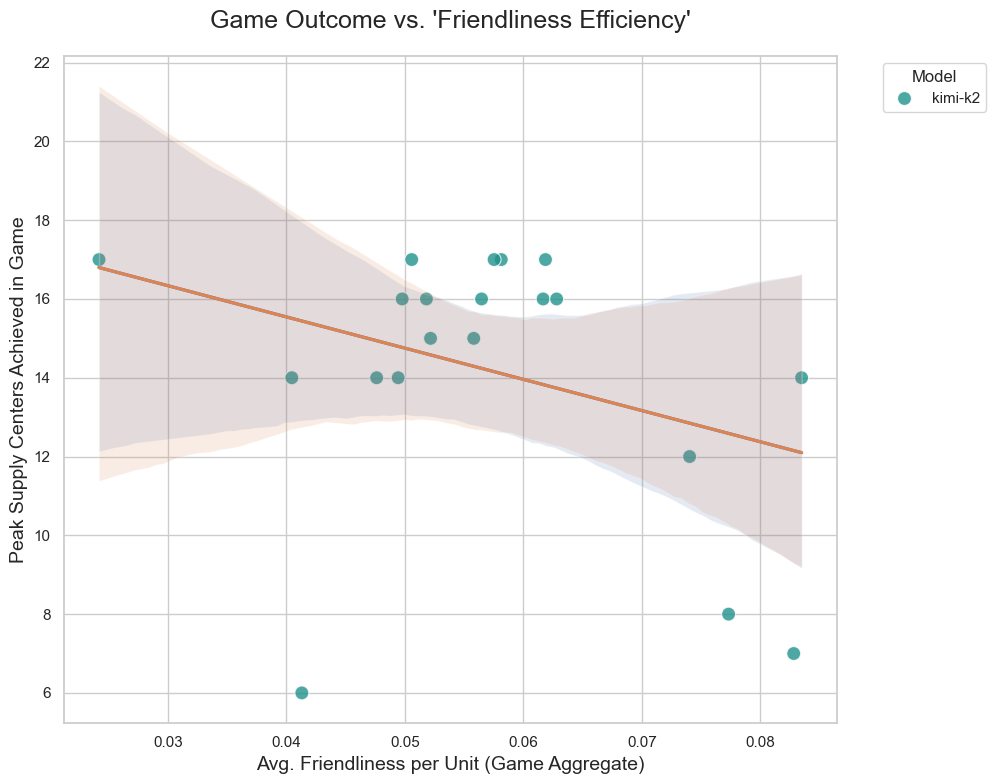

In [16]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# ---------------------------------------------------------------------------
# Configuration: Edit the list of experiment folders to compare
# ---------------------------------------------------------------------------
exp_dirs = {
    #"o3": "../data/sam-exp113-bench",
    #"o4-mini": "../data/sam-exp112-bench",
    "kimi-k2": "../data/sam-exp080-bench",
    #"gpt-4.1-nano": "../data/sam-exp092-bench",
    #"llama-3.3-70b-instruct": "../data/sam-exp106-bench",
}

# ---------------------------------------------------------------------------
# Helper Functions
# ---------------------------------------------------------------------------
def calculate_avg_relationship(relationship_str: str) -> float:
    """
    Parses the relationship string and calculates the average of the defined values.
    """
    if not isinstance(relationship_str, str):
        return np.nan
    values = re.findall(r':(-?\d+\.?\d*)', relationship_str)
    if not values:
        return np.nan
    return np.mean([float(v) for v in values])

def normalize_value(value, old_min, old_max, new_min, new_max):
    """Scales a value from an old range to a new range."""
    return new_min + (value - old_min) * (new_max - new_min) / (old_max - old_min)

# ---------------------------------------------------------------------------
# 1. Process each game to calculate the two aggregate metrics
# ---------------------------------------------------------------------------
game_summary_records = []

print("Processing games from all specified experiments...")
for model_label, exp_dir in exp_dirs.items():
    exp_path = Path(exp_dir).expanduser().resolve()
    csv_dir = exp_path / "analysis" / "statistical_game_analysis" / "individual"
    
    if not csv_dir.exists():
        print(f"warning: directory not found, skipping model '{model_label}': {csv_dir}")
        continue
        
    csv_files = sorted(csv_dir.glob("run_*_phase_analysis.csv"))
    print(f"-> Found {len(csv_files)} games for '{model_label}'")
    
    for csv_file in csv_files:
        try:
            # Each CSV file represents one full game
            game_df = pd.read_csv(csv_file)
            
            # Filter for France and the 'order_generation' rows
            france_game_df = game_df[
                (game_df["power_name"] == "FRANCE") &
                (game_df["analyzed_response_type"] == "order_generation")
            ].copy()
            
            if france_game_df.empty:
                continue

            # --- Metric 1: Aggregate "Friendliness per Unit" for the game ---
            # Calculate relationship and normalize it for each phase
            france_game_df['avg_relationship'] = france_game_df['relationships'].apply(calculate_avg_relationship)
            france_game_df['norm_relationship'] = normalize_value(
                france_game_df['avg_relationship'], old_min=-1.0, old_max=1.0, new_min=0.2, new_max=1.0
            )
            # Calculate the per-phase metric
            france_game_df['relationship_per_unit'] = france_game_df['norm_relationship'] / france_game_df['military_units_count']
            france_game_df.replace([np.inf, -np.inf], np.nan, inplace=True)
            
            # Now, aggregate this metric for the entire game by taking the mean
            game_friendliness_per_unit = france_game_df['relationship_per_unit'].mean()

            # --- Metric 2: Max Supply Centers for the game ---
            game_max_sc = france_game_df['supply_centers_owned_count'].max()

            # Store the results for this game
            game_summary_records.append({
                "model": model_label,
                "game_friendliness_per_unit": game_friendliness_per_unit,
                "max_supply_centers": game_max_sc,
            })
            
        except Exception as exc:
            print(f"warning: could not process {csv_file} – {exc}")

if not game_summary_records:
    raise RuntimeError("No data collected. Check paths and file contents.")

# Create the final DataFrame for plotting
plot_df = pd.DataFrame(game_summary_records)

print("\n" + "="*60)
print("Generated Data for Plotting (each row is one game)")
print("="*60)
print(plot_df.head())
print("\n--- Summary Statistics ---")
print(plot_df.groupby('model').agg(['mean', 'std', 'count']))
print("-"*60)


# ---------------------------------------------------------------------------
# 2. Create the Scatter Plot
# ---------------------------------------------------------------------------
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

ax = sns.scatterplot(
    data=plot_df,
    x="game_friendliness_per_unit",
    y="max_supply_centers",
    hue="model",  # Color points by model
    style="model", # Use different markers for each model
    s=100,        # Increase marker size
    alpha=0.8,
    palette="viridis",
    hue_order=exp_dirs.keys() # Ensure consistent legend order
)

# Add a regression line for each model to visualize the trend
sns.regplot(
    data=plot_df,
    x="game_friendliness_per_unit",
    y="max_supply_centers",
    scatter=False, # Don't draw the scatter points again
    ax=ax,
    # This part is a bit tricky: we need to plot one regline per model
    # The easiest way is to loop, but let's try a more direct approach if possible.
    # A simple regplot on the whole data is misleading. Let's loop.
)

# Looping to create a regression line for each model is more accurate
for model in exp_dirs.keys():
    model_data = plot_df[plot_df['model'] == model]
    if not model_data.empty:
        sns.regplot(
            data=model_data,
            x='game_friendliness_per_unit',
            y='max_supply_centers',
            scatter=False,
            label=f'{model} trend',
            ax=ax
        )


ax.set_title("Game Outcome vs. 'Friendliness Efficiency'", fontsize=18, pad=20)
ax.set_xlabel("Avg. Friendliness per Unit (Game Aggregate)", fontsize=14)
ax.set_ylabel("Peak Supply Centers Achieved in Game", fontsize=14)

# Improve legend
handles, labels = ax.get_legend_handles_labels()
# The regplot adds extra labels, so we filter to only show the scatterplot legend
num_models = len(exp_dirs)
ax.legend(handles[:num_models], labels[:num_models], title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.show()

Processing data from all specified experiments...


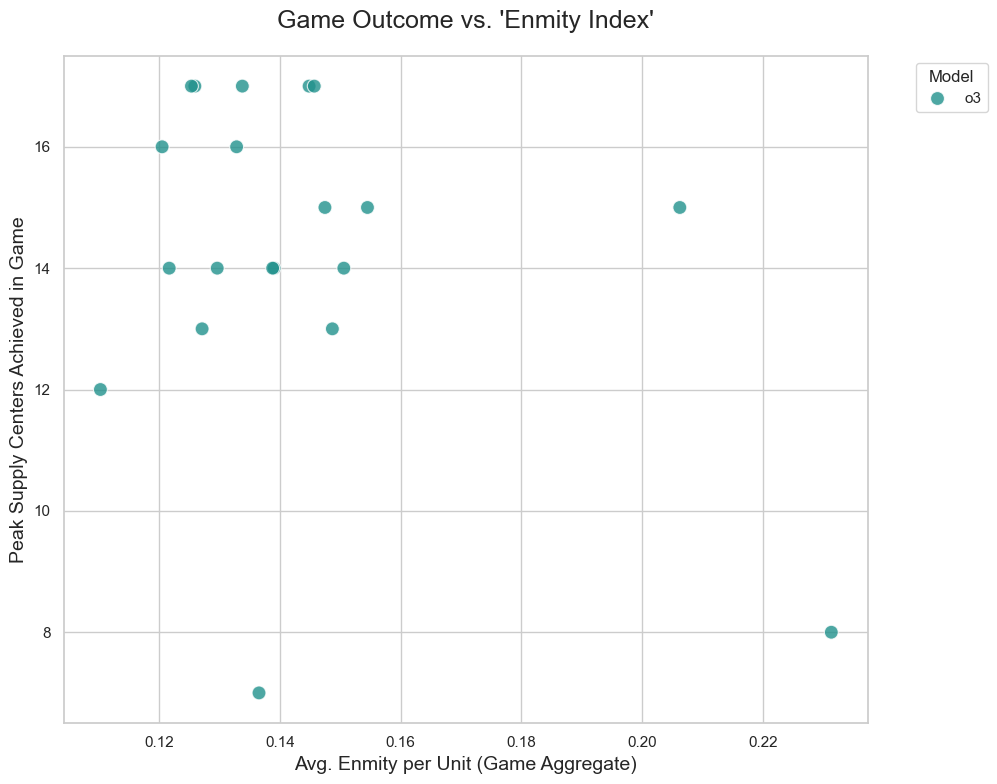

<Figure size 1200x800 with 0 Axes>

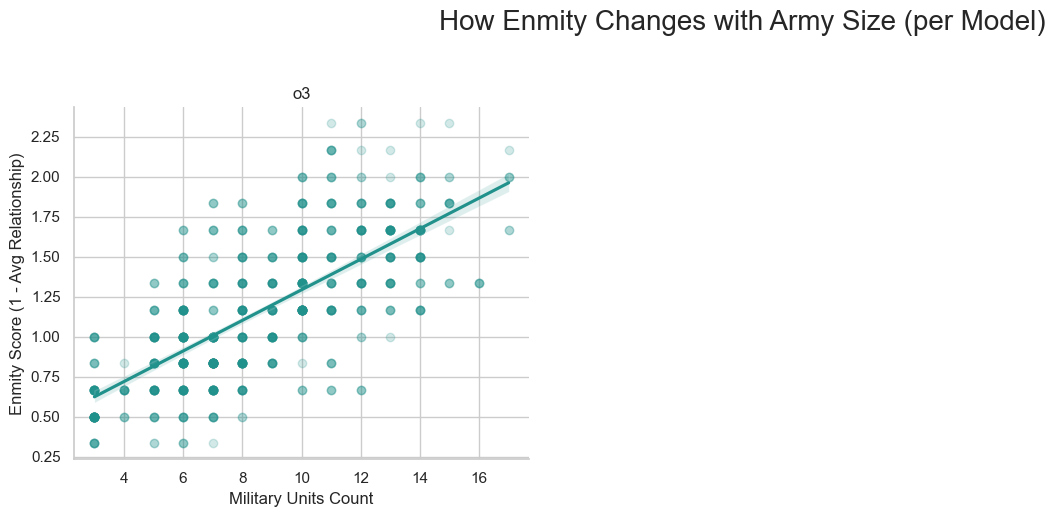

In [17]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# ---------------------------------------------------------------------------
# Configuration: Edit the list of experiment folders to compare
# ---------------------------------------------------------------------------
exp_dirs = {
    "o3": "../data/sam-exp113-bench",
    #"o4-mini": "../data/sam-exp112-bench",
    #"kimi-k2": "../data/sam-exp080-bench",
    #"gpt-4.1-nano": "../data/sam-exp092-bench",
    #"llama-3.3-70b-instruct": "../data/sam-exp106-bench",
}

# ---------------------------------------------------------------------------
# Helper Functions
# ---------------------------------------------------------------------------
def calculate_avg_relationship(relationship_str: str) -> float:
    if not isinstance(relationship_str, str): return np.nan
    values = re.findall(r':(-?\d+\.?\d*)', relationship_str)
    if not values: return np.nan
    return np.mean([float(v) for v in values])

# ---------------------------------------------------------------------------
# 1. Load and Process Data
# ---------------------------------------------------------------------------
all_phase_data = []

print("Processing data from all specified experiments...")
for model_label, exp_dir in exp_dirs.items():
    exp_path = Path(exp_dir).expanduser().resolve()
    csv_dir = exp_path / "analysis" / "statistical_game_analysis" / "individual"
    
    if not csv_dir.exists():
        print(f"warning: directory not found, skipping model '{model_label}': {csv_dir}")
        continue
        
    csv_files = sorted(csv_dir.glob("run_*_phase_analysis.csv"))
    
    for csv_file in csv_files:
        try:
            game_df = pd.read_csv(csv_file)
            game_df['model'] = model_label
            game_df['game_id'] = f"{model_label}_{csv_file.stem}"
            
            france_df = game_df[
                (game_df["power_name"] == "FRANCE") &
                (game_df["analyzed_response_type"] == "order_generation")
            ].copy()
            
            if not france_df.empty:
                all_phase_data.append(france_df)
        except Exception as exc:
            print(f"warning: could not process {csv_file} – {exc}")

if not all_phase_data:
    raise RuntimeError("No data collected. Check paths and file contents.")

# Create a single DataFrame with data from every phase of every game
phase_df = pd.concat(all_phase_data, ignore_index=True)

# ---------------------------------------------------------------------------
# 2. Feature Engineering
# ---------------------------------------------------------------------------
# Calculate relationship and the new "enmity score"
phase_df['avg_relationship'] = phase_df['relationships'].apply(calculate_avg_relationship)
phase_df['enmity_score'] = 1 - phase_df['avg_relationship'] # Ranges from 0 (no enemies) to 2 (all enemies)

# Calculate the "enmity per unit" index
phase_df['enmity_per_unit'] = phase_df['enmity_score'] / phase_df['military_units_count']
phase_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# For plotting, get the max supply centers for each game and map it back to every phase
phase_df['max_supply_centers'] = phase_df.groupby('game_id')['supply_centers_owned_count'].transform('max')

# Drop rows where metrics could not be calculated
phase_df.dropna(subset=['enmity_per_unit', 'max_supply_centers'], inplace=True)


# ---------------------------------------------------------------------------
# 3. Analysis 1: The "Enmity Index" Approach
# ---------------------------------------------------------------------------
# Aggregate the "enmity per unit" for each game
game_summary_df = phase_df.groupby(['game_id', 'model']).agg(
    avg_enmity_per_unit=('enmity_per_unit', 'mean'),
    max_supply_centers=('max_supply_centers', 'first') # 'first' is efficient since it's the same for all rows of a game
).reset_index()

plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

ax1 = sns.scatterplot(
    data=game_summary_df,
    x="avg_enmity_per_unit",
    y="max_supply_centers",
    hue="model",
    style="model",
    s=100,
    alpha=0.8,
    palette="viridis",
    hue_order=exp_dirs.keys()
)

ax1.set_title("Game Outcome vs. 'Enmity Index'", fontsize=18, pad=20)
ax1.set_xlabel("Avg. Enmity per Unit (Game Aggregate)", fontsize=14)
ax1.set_ylabel("Peak Supply Centers Achieved in Game", fontsize=14)
ax1.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# ---------------------------------------------------------------------------
# 4. Analysis 2: The "Direct Relationship" Approach (More revealing)
# ---------------------------------------------------------------------------
plt.figure(figsize=(12, 8))

# Use a FacetGrid to create a separate subplot for each model
g = sns.FacetGrid(phase_df, col="model", col_wrap=3, hue="model", palette="viridis", height=5, col_order=exp_dirs.keys())

# For each subplot, draw a scatterplot and a regression line
g.map_dataframe(sns.regplot, x="military_units_count", y="enmity_score", scatter_kws={'alpha': 0.2})

g.fig.suptitle("How Enmity Changes with Army Size (per Model)", fontsize=20, y=1.03)
g.set_axis_labels("Military Units Count", "Enmity Score (1 - Avg Relationship)")
g.set_titles(col_template="{col_name}")
g.tight_layout(w_pad=1)

plt.show()